# Define a few stuff, import a few stuff

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random
import collections

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_ipac_confirmed_200507.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[77]
VALUES = raw_data[78:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return arr

In [4]:
'''
What I need:
- star name 
- planet radius --> comes from planet mass
- star mass
- planet mass
- planet semi-major axis --> comes from planet's period
- star radius
'''

d = {}
d['starname'] = get_key('pl_hostname')  #get star name

d['radius'] = get_key('pl_radj')  #get radius of planets (Jupiter radius)
d['star_radius'] = get_key('st_rad')  #get radius of star (solar radii)

d['mp'] = get_key('pl_bmassj')  #get mass of planets (in Jupiter masses)
                                #mass can be expressed as Msin(i), where i is the inclination

d['ms'] = get_key('st_mass')  #get mass of stars (in solar masses)

d['a'] = get_key('pl_orbsmax')  #get planet's semi-major axis (in AU)

d['p'] = get_key('pl_orbper')  #get planet's period (in days)

d['disc_method'] = get_key('pl_discmethod')  #get planet's discovery method

d['mag'] = get_key('st_optmag') #get star's optical (apparent) magntiude

d['temp'] = get_key('st_teff') #get star's effective temperature (K)

d['i'] = get_key('pl_orbincl') #get star's inclination (degrees)

In [5]:
'''
Take all the M-dwarves from the RV data
'''

def is_number(num):
    '''
    Checks if a piece of data (in string format) is a number or not.
    '''
    try:
        float(num)
        return True
    except ValueError:
        return False   
    
def convert_to_float(arr):            #all of the values in these arrays are numbers, so 
    final = []                        #strings can be converted into numbers.
    for a in arr:
        final.append(float(a))
    return final

def mdwarf_mass_condition(mass):
    '''
    mass - float
    '''
    if is_number(mass) == False:
        return False
    mass = float(mass)
    if mass >= 0.08:
        if mass < 0.8:
            return True
    return False

def stellar_mass_condition(mass):
    '''
    mass - float
    '''
    if is_number(mass) == False:
        return False
    mass = float(mass)
    if mass >= 0.8:
        return True
    return False

def mass_radius(mp): 
    '''
    mp - float
    
    Uses the mass-radius relation given in Chen and Kipping (2016).  This method takes mass and 
    outputs radius.  mp is given in Jupiter masses, and rp is returned in Jupiter radii.  The -0.291, 16.580, and -7826.573 
    were calculated using the boundary conditions.
    '''
    
    if type(mp) != list:
        if mp <= 2:                                          
            rp = 10**0.00346*mp**0.2790*REARTH/RJUPITER
        elif mp*MEARTH/MJUPITER <= 0.41:
            rp = 10**-0.0925*mp**0.589*REARTH/RJUPITER
        elif mp*MEARTH/MSUN <= 0.08:
            rp = 10**1.25*mp**-0.044*REARTH/RJUPITER
        else:
            rp = 10**-2.85*mp**0.881*REARTH/RJUPITER
    else:
        rp = []
        mp = np.array(mp).astype(float)
        for m in mp:
            if m <= 2:                                          
                rp.append(10**0.00346*m**0.2790*REARTH/RJUPITER)
            elif m*MEARTH/MJUPITER <= 0.41:
                rp.append(10**-0.0925*m**0.589*REARTH/RJUPITER)
            elif m*MEARTH/MSUN <= 0.08:
                rp.append(10**1.25*m**-0.044*REARTH/RJUPITER)
            else:
                rp.append(10**-2.85*m**0.881*REARTH/RJUPITER)
        rp = np.array(rp).astype(float)
    return rp 

for i in range(len(d['mp'])):           #calculating the exoplanet radii from the mass-radius relation.
    if is_number(d['mp'][i]) == True:
        if d['radius'][i] == '':
            m = float(d['mp'][i])    
            m = m*MJUPITER/MEARTH
            d['radius'][i] = mass_radius(m)

In [6]:
mdwarves = {}
mdwarves['detection_method'] = []
mdwarves['rp'] = []
mdwarves['rs'] = []
mdwarves['mp'] = []
mdwarves['ms'] = []
mdwarves['p'] = []
mdwarves['starname'] = []

for i in range(len(d['ms'])):
    if mdwarf_mass_condition(d['ms'][i]) == True and is_number(d['radius'][i]) and is_number(d['star_radius'][i]) \
        and is_number(d['mp'][i]) and is_number(d['ms'][i]) and is_number(d['p'][i]):
        mdwarves['rp'].append(d['radius'][i])
        mdwarves['rs'].append(d['star_radius'][i])
        mdwarves['mp'].append(d['mp'][i])
        mdwarves['ms'].append(d['ms'][i])
        mdwarves['p'].append(d['p'][i])
        mdwarves['detection_method'].append(d['disc_method'][i])
        mdwarves['starname'].append(d['starname'][i])

mdwarves['rp'] = (RJUPITER/REARTH*np.array(convert_to_float(mdwarves['rp']))).tolist()
mdwarves['rs'] = convert_to_float(mdwarves['rs'])
mdwarves['mp'] = (MJUPITER/MEARTH*np.array(convert_to_float(mdwarves['mp']))).tolist()
mdwarves['ms'] = convert_to_float(mdwarves['ms'])
mdwarves['p'] = convert_to_float(mdwarves['p'])

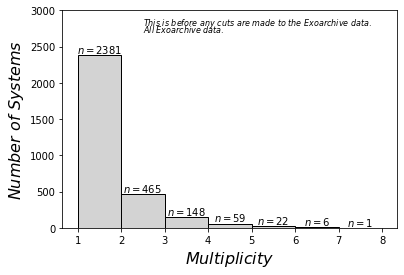

In [7]:
systems = collections.Counter(d['starname'])
multiplicities = []                            #get the number of planets (multiplicity) for each system
for key, value in systems.items():             #before any cuts are made to the data
    multiplicities.append(value)
multiplicities = np.array(multiplicities)

plt.ylim(0, 3000)
plt.ylabel(r'$Number\ of\ Systems$', fontsize=16)
plt.xlabel(r'$Multiplicity$', fontsize=16)               #making a histogram

plt.hist(multiplicities, bins = 7, color = 'lightgrey', edgecolor = 'k')
for i in range(1, 8):
    plt.text(i+0.5, np.sum(multiplicities==i), r'$n = %d$' %np.sum(multiplicities==i), va='bottom', \
    ha='center', fontsize=10)
plt.text(2.5, 2800, r'$This\ is\ before\ any\ cuts\ are\ made\ to\ the\ Exoarchive\ data.$', fontsize=8)
plt.text(2.5, 2700, r'$All\ Exoarchive\ data.$', fontsize=8)
plt.show()

In [8]:
stars = []   #convert to arrays
rp = []
rs = []
mp = []
ms = []
a = []
p = []
detection_methods = []

'''
Making sure all the data is of the right data type and all planets were detected using the RV technique.
'''

for i in range(len(d['a'])):
    if is_number(d['mp'][i]) and is_number(d['ms'][i]) and is_number(d['a'][i]) and is_number(d['star_radius'][i]) \
    and is_number(d['p'][i]) and 'Radial' in d['disc_method'][i]:
        if stellar_mass_condition(d['ms'][i]):
            stars.append(d['starname'][i])
            rp.append(d['radius'][i])
            mp.append(d['mp'][i])
            ms.append(d['ms'][i])
            a.append(d['a'][i])
            rs.append(d['star_radius'][i])
            p.append(d['p'][i])
            detection_methods.append(d['disc_method'][i])

In [9]:
stars_transit = []   #convert to arrays
rp_transit = []
rs_transit = []
mp_transit = []
ms_transit = []
a_transit = []
p_transit = []
for i in range(len(d['a'])):
    if is_number(d['mp'][i]) and is_number(d['ms'][i]) and is_number(d['a'][i]) and is_number(d['star_radius'][i]) \
    and is_number(d['p'][i]) and 'Transit' in d['disc_method'][i]:
        if stellar_mass_condition(d['ms'][i]):
            stars_transit.append(d['starname'][i])
            rp_transit.append(d['radius'][i])
            mp_transit.append(d['mp'][i])
            ms_transit.append(d['ms'][i])
            a_transit.append(d['a'][i])
            rs_transit.append(d['star_radius'][i])
            p_transit.append(d['p'][i])
            
rp_transit = np.array(convert_to_float(rp_transit))
rs_transit = np.array(convert_to_float(rs_transit))
mp_transit = np.array(convert_to_float(mp_transit))
ms_transit = np.array(convert_to_float(ms_transit))
a_transit = np.array(convert_to_float(a_transit))
p_transit = np.array(convert_to_float(p_transit))
stars_transit = np.array(stars_transit)

uniquesys = np.unique(stars_transit)
systems = []
for us in uniquesys:
    s = System()
    s.sysid = us
    s.Mstar = ms_transit[stars_transit==us][0]
    if stellar_mass_condition(s.Mstar) == True and len(mp_transit[stars_transit==us]) > 1:
        s.masses = mp_transit[stars_transit==us]*MJUPITER/MEARTH
        s.periods = p_transit[stars_transit==us]
        order = np.argsort(s.periods)
        s.masses = s.masses[order]
        s.periods = s.periods[order]

        s.N = len(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.logmu = np.log10(s.mu)
        s.logmuoverN = np.log10(s.mu/s.N)
        s.Q = archinfo.Q(s.masses)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)

        systems.append(s)
    
    
Nsys = len(uniquesys)
N_transit = np.zeros(Nsys)
logmu_transit = np.zeros(Nsys)
logmuoverN_transit = np.zeros(Nsys)
Q_transit = np.zeros(Nsys)
M_transit = np.zeros(Nsys)
S_transit = np.zeros(Nsys)
C_transit = np.zeros(Nsys)
new_mass_transit = np.zeros(Nsys)

for i, s in enumerate(systems):
    N_transit[i]  = s.N
    logmu_transit[i] = s.logmu
    logmuoverN_transit[i] = s.logmuoverN
    Q_transit[i]  = s.Q
    M_transit[i]  = s.M
    S_transit[i]  = s.S
    C_transit[i]  = s.C
    new_mass_transit[i] = s.Mstar

ms_transit = new_mass_transit
    
ms_transit = ms_transit[N_transit >= 3]    
Q_transit = Q_transit[N_transit >= 3]
M_transit = M_transit[N_transit >= 3]
S_transit = S_transit[N_transit >= 3]
C_transit = C_transit[N_transit >= 3]
logmuoverN_transit = logmuoverN_transit[N_transit >= 3]
logmu_transit = logmu_transit[N_transit >= 3]
N_transit = N_transit[N_transit >= 3]
ms_transit = ms_transit[logmu_transit < -1]
Q_transit = Q_transit[logmu_transit < -1]
M_transit = M_transit[logmu_transit < -1]
S_transit = S_transit[logmu_transit < -1]
C_transit = C_transit[logmu_transit < -1]
logmuoverN_transit = logmuoverN_transit[logmu_transit < -1]
N_transit = N_transit[logmu_transit < -1]
logmu_transit = logmu_transit[logmu_transit < -1]

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:186: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')


In [10]:
rp = convert_to_float(rp)
rs = convert_to_float(rs)
mp = convert_to_float(mp)
ms = convert_to_float(ms)
a = convert_to_float(a)
p = convert_to_float(p)

In [11]:
uniquestars = []
uniquems = []
for i in range(len(stars)):
    if stars[i] not in uniquestars:              #one instance of each star in uniquestars
        uniquestars.append(stars[i])             #obtaining the mass of each star in uniquestars for convenience
        uniquems.append(ms[i])

In [12]:
def split_array(arr, s = stars, u = uniquestars):
    '''
    arr - 1D float list
    
    This method should take a 1D float list and split it up into different systems.
    In the end, it should output a list of lists, with each sublist being of variable length.
    '''
    final_array = []
    corresponding_stars = []
    for i in range(len(u)):
        mini_array = []
        for j in range(len(s)):
            if s[j] == u[i]:
                mini_array.append(arr[j])
        if len(mini_array) >= 3:
            final_array.append(mini_array)
            corresponding_stars.append(u[i])
    return final_array, corresponding_stars

rs_final, stars_that_matter = split_array(rs)
rp_final, stars_that_matter = split_array(rp)
mp_final, stars_that_matter = split_array(mp)
ms_final, stars_that_matter = split_array(ms)
a_final, stars_that_matter = split_array(a)
p_final, stars_that_matter = split_array(p)
detection_methods_final, stars_that_matter = split_array(detection_methods)

number_of_planets = 0
for i in range(len(rp_final)):
    for j in range(len(rp_final[i])):
        number_of_planets = number_of_planets + 1

mu_final = []                                                         #calculate dynamical mass for each system
for i in range(len(mp_final)):
    mu_final.append(archinfo.mu((MJUPITER/MEARTH)*np.array(mp_final[i]), ms_final[i][0]))
  
"""
Anything with _raw attached to it is basically a 1D list.

rs_raw = [item for sublist in rs_final for item in sublist]
rp_raw = [item for sublist in rp_final for item in sublist]
p_raw = [item for sublist in p_final for item in sublist]
"""
                                                                 #check to see how much of the original data is left
print("Number of original planets: " + str(len(d['starname'])))                      
print("After filtering data, new number of planets: " + str(len([item for sublist in rp_final for item in sublist])))  

Number of original planets: 4152
After filtering data, new number of planets: 42


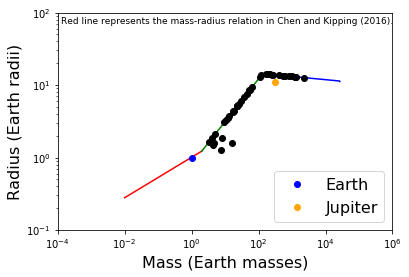

In [13]:
'''
Print masses and radii of each remaining planet to check if they are consistent.
'''
masses = np.array([item for sublist in mp_final for item in sublist])
radii = np.array([item for sublist in rp_final for item in sublist])

x = np.linspace(0.01, 2, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-r')

x = np.linspace(2, 0.41*MJUPITER/MEARTH, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-g')

x = np.linspace(0.41*MJUPITER/MEARTH, 0.08*MSUN/MEARTH, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-b')

plt.plot(masses*MJUPITER/MEARTH, radii*RJUPITER/REARTH, 'o', color='black')
                                                                              #add in Earth and Jupiter for reference
plt.plot(1, 1, 'o', color='blue', label='Earth')                                                 #Earth
plt.plot(MJUPITER/MEARTH, RJUPITER/REARTH, 'o', color='orange', label='Jupiter')                 #Jupiter

plt.xlabel('Mass (Earth masses)', fontsize=16)
plt.xscale("log")
plt.xlim(10**-4, 10**6)
plt.ylabel('Radius (Earth radii)', fontsize=16)
plt.yscale("log")
plt.ylim(10**-1, 10**2)
plt.text(10**-3.9, 70, 'Red line represents the mass-radius relation in Chen and Kipping (2016).', fontsize=9)

plt.legend(loc='lower right', fontsize=16)

'''
There are a couple RV planets whose radii are already known.
'''

plt.show()

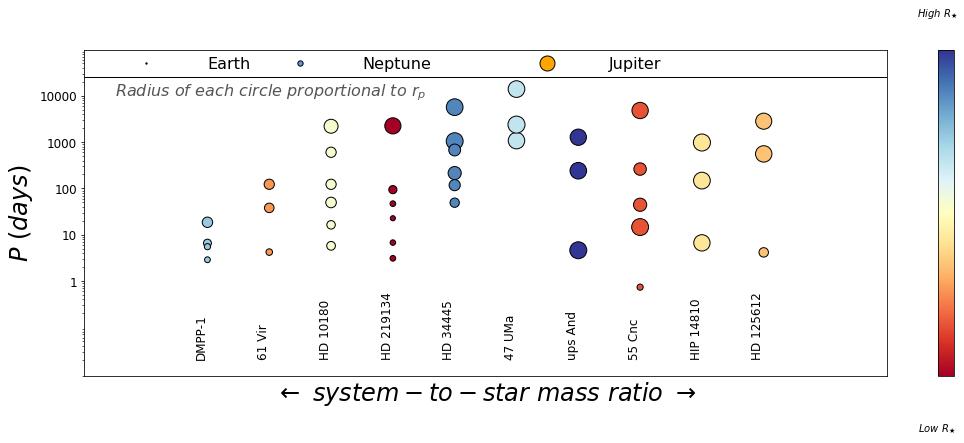

In [14]:
'''
Print information related to every planet after the cuts are made.

Display gallery of systems in the Exoarchive data.  This contains both RV and transit data.
'''

mu_rank = np.array(stats.rankdata(mu_final), dtype = 'int')
mu_pos = []
for i in range(len(mu_final)):
    for j in range(len(mp_final[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

rs_rank = np.array(stats.rankdata([item for sublist in rs_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()
   
plt.scatter(mu_pos, [item for sublist in p_final for item in sublist], c = rs_rank, cmap = cm, \
s = 225*np.array([item for sublist in rp_final for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(rs_rank), max(rs_rank))
cbar.set_ticks([])
cbar.ax.text(1, -5, r"$Low\ R_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 45, r"$High\ R_{\bigstar}$", va = 'top', ha = 'center')


for i in range(len(rp_final)):
    plt.text(mu_rank[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(1, 50000, 'Earth', va='center', fontsize=16)
plt.plot(2.5, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(3.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(6.5, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(7.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.5,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')
plt.show()

In [15]:
'''
Calculate information parameters for each system(N, Q, M, etc.)
'''

N_final = []
for i in range(len(mp_final)):
    N_final.append(len(mp_final[i]))

#we already have mu_final

sv_p_final = p_final
sv_mp_final = mp_final 
for i in range(len(mp_final)):                                     #convert to Earth masses
    sv_p_final[i] = np.array(p_final[i])                           #sort each system by increasing period
    sv_mp_final[i] = (MJUPITER/MEARTH)*np.array(mp_final[i])       #that will play a role in the value of S
    order = np.argsort(sv_p_final[i])
    sv_p_final[i] = sv_p_final[i][order]
    sv_mp_final[i] = sv_mp_final[i][order]

Q_final = []
for i in range(len(mp_final)):
    Q_final.append(archinfo.Q(sv_mp_final[i]))
    
M_final = []
for i in range(len(mp_final)):
    M_final.append(archinfo.M(sv_p_final[i], sv_mp_final[i]))
    
S_final = []
for i in range(len(mp_final)):
    S_final.append(archinfo.S(sv_p_final[i], sv_mp_final[i], ms_final[i][0]))

    
C_final = []
for i in range(len(p_final)):
    C_final.append(archinfo.C(sv_p_final[i])[0])

"""
for i in range(len(S_final)):
    print(str(S_final[i]) + " " + stars_that_matter[i])
"""


N_final = np.array(N_final)
Q_final = np.array(Q_final)
M_final = np.array(M_final)
S_final = np.array(S_final)
C_final = np.array(C_final)
logmu_final = np.log10(np.array(mu_final))

log_mu_over_N = []
for i in range(len(mu_final)):
    log_mu_over_N.append(np.log10(mu_final[i]/N_final[i]))
log_mu_over_N = np.array(log_mu_over_N)

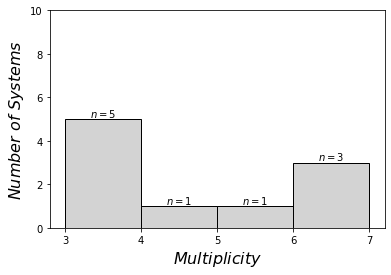

In [16]:
'''
Making a histogram of multiplicities
'''

plt.ylim(0, 10)
plt.ylabel(r'$Number\ of\ Systems$', fontsize=16)
plt.xlabel(r'$Multiplicity$', fontsize=16)               #making a histogram

plt.hist(N_final, bins = np.arange(3, 8, 1), color = 'lightgrey', edgecolor = 'k')
for i in range(3, 7):
    plt.text(i+0.5, np.sum(N_final==i), r'$n = %d$' %np.sum(N_final==i), va='bottom', \
    ha='center', fontsize=10)
plt.xticks([3, 4, 5, 6, 7])
plt.show()

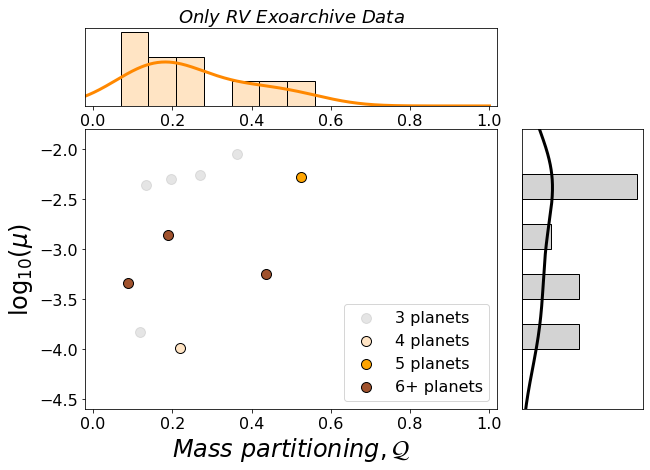

In [17]:
'''
Make Q vs. mu scatter plot and histograms
'''

plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q_final[N_final==4], logmu_final[N_final==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q_final[N_final==5], logmu_final[N_final==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q_final[N_final>=6], logmu_final[N_final>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(-4.6, -1.8)

#Q histogram
x = np.linspace(-1, 1, 1000)
y = FFTKDE(kernel = 'gaussian', bw = 'silverman').fit(np.hstack([Q_final])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(Q_final, bins=np.arange(0,1,0.07), density=True, color='bisque', edgecolor='k')
ax1h.plot(x, y, c='#ff8800', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.25), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])
ax1h.tick_params(labelsize=16)


plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


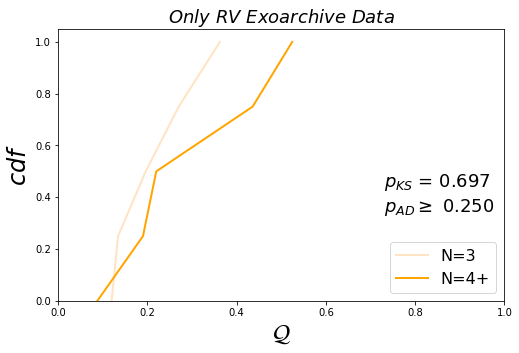

In [18]:
'''
Make Q cdf
Distinguish between N=3 and N=4+ systems
'''

#Q cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

Q3 = Q_final[N_final==3]
Q4 = Q_final[N_final>=4]

Q3 = np.sort(np.squeeze(Q3))
Q4 = np.sort(np.squeeze(Q4))

ax.plot(Q3, np.linspace(0,1,len(Q3)), lw=2, color='bisque', label='N=3')
ax.plot(Q4, np.linspace(0,1,len(Q4)), lw=2, color='orange', label='N=4+')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(Q3, Q4))
AD = stats.anderson_ksamp([Q3, Q4])[2]

ax.text(0.73, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(0.73, 0.4, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

plt.show()

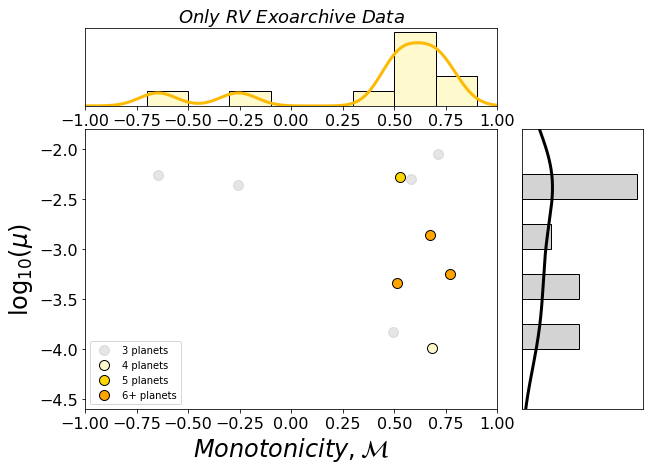

In [19]:
'''
Make M vs. mu scatter plot and histograms
'''

plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M_final[N_final==4], logmu_final[N_final==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M_final[N_final==5], logmu_final[N_final==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M_final[N_final>=6], logmu_final[N_final>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower left', frameon=True, fontsize=10)
ax1.tick_params(labelsize=16)

ax1.set_xlim(-1, 1)
ax1.set_ylim(-4.6, -1.8)

#M histogram
x = np.linspace(-1.5,1.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_final)).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(M_final, bins=np.arange(-1.5,1.5,0.2), density=True, color='lemonchiffon', edgecolor='k')
ax1h.plot(x, y, c='#fcba03', lw=3)
ax1h.set_xlim(-1,1)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.25), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

ax1h.tick_params(labelsize=16)

plt.show()

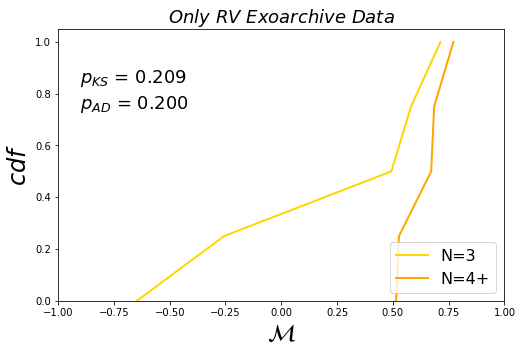

In [20]:
'''
Make M cdf
Distinguish between N=3 and N=4+ systems
'''

#M cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

M3 = M_final[N_final==3]
M4 = M_final[N_final>=4]

M3 = np.sort(np.squeeze(M3))
M4 = np.sort(np.squeeze(M4))

ax.plot(M3, np.linspace(0,1,len(M3)), lw=2, color='gold', label='N=3')
ax.plot(M4, np.linspace(0,1,len(M4)), lw=2, color='orange', label='N=4+')
ax.set_xlim(-1,1)
ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(M3, M4))
AD = stats.anderson_ksamp([M3, M4])[2]

ax.text(-0.9, 0.9, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-0.9, 0.8, r'$p_{AD}$ = %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

plt.show()

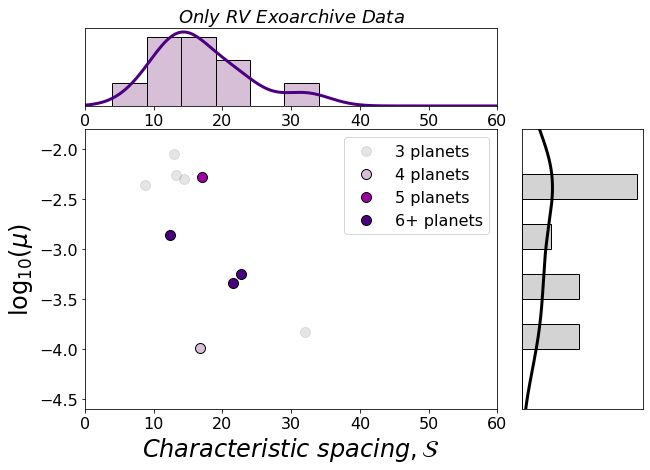

In [21]:
'''
Make S vs. mu scatter plot and histograms
'''

plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S_final[N_final==4], logmu_final[N_final==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S_final[N_final==5], logmu_final[N_final==5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
ax1.scatter(S_final[N_final>=6], logmu_final[N_final>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='upper right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

ax1.set_xlim(0, 60)
ax1.set_ylim(-4.6, -1.8)

#S histogram
x = np.linspace(-1,100,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_final)).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(S_final, bins=np.arange(-1,75,5), density=True, color='thistle', edgecolor='k')
ax1h.plot(x, y, c='indigo', lw=3)
ax1h.set_xlim(0, 60)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.25), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


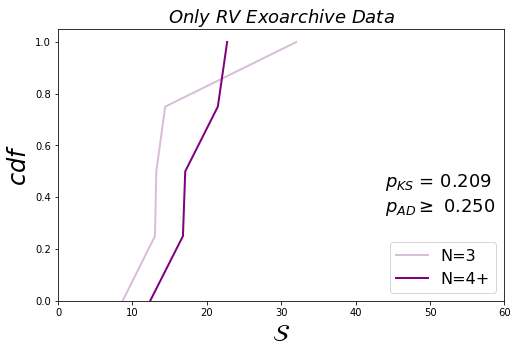

In [22]:
'''
Make S cdf
Distinguish between N=3 and N=4+ systems
'''

#S cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

S3 = S_final[N_final==3]
S4 = S_final[N_final>=4]

S3 = np.sort(np.squeeze(S3))
S4 = np.sort(np.squeeze(S4))

ax.plot(S3, np.linspace(0,1,len(S3)), lw=2, color='thistle', label='N=3')
ax.plot(S4, np.linspace(0,1,len(S4)), lw=2, color='purple', label='N=4+')
ax.set_xlim(0,60)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(S3, S4))
AD = stats.anderson_ksamp([S3, S4])[2]

ax.text(44, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(44, 0.4, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

plt.show()

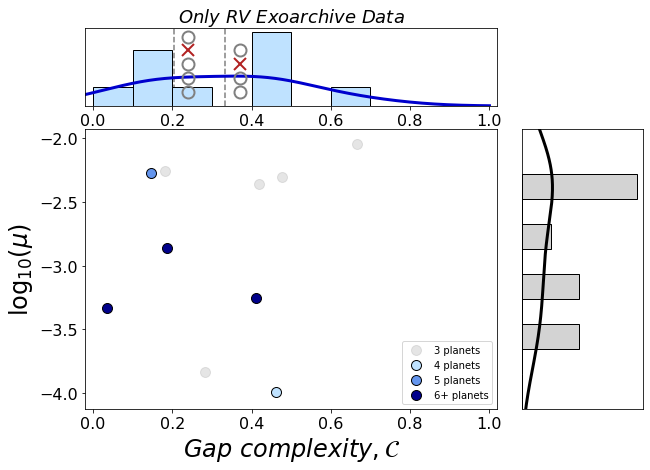

In [23]:
'''
Make C vs. mu scatter plot and histograms
'''

P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C_final[N_final==3], logmu_final[N_final==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C_final[N_final==4], logmu_final[N_final==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
ax1.scatter(C_final[N_final==5], logmu_final[N_final==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C_final[N_final>=6], logmu_final[N_final>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=10)
plt.xlim(-0.02, 1.02)
ax1.tick_params(labelsize=16)

#C histogram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([C_final])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(C_final, bins=np.arange(-1,1,0.1), density=True, color=robinseggblue, edgecolor='k')
ax1h.plot(x, y, c='mediumblue', lw=3)
ax1h.set_xlim(-0.02, 1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

'''
Add gap complexities where systems with missing planets would be
'''

ax1h.axvline(C43, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.37,0.37,0.37], [0.75,1.5,3], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.37], [2.25], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

ax1h.axvline(C54, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.24,0.24,0.24, 0.24], [0.75,1.5,2.25,3.75], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.24], [3], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


#mu histogram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_final).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu_final,bins=np.arange(-5,-2,0.25), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=3, c='k')
axsh.set_yticks([])
axsh.set_ylim(-4.6,-1.8)
axsh.set_xticks([])

plt.show()

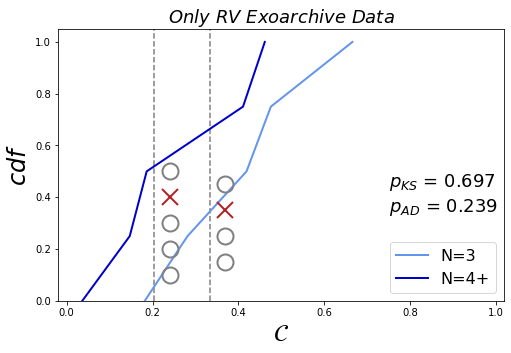

In [24]:
'''
Make C cdf
Distinguish between N=3 and N=4+ systems
'''

#C cdf
fix, ax = plt.subplots(1, figsize = (8, 5))

C3 = C_final[N_final==3]
C4 = C_final[N_final>=4]

C3 = np.sort(np.squeeze(C3))
C4 = np.sort(np.squeeze(C4))

ax.plot(C3, np.linspace(0,1,len(C3)), lw=2, color='cornflowerblue', label='N=3')
ax.plot(C4, np.linspace(0,1,len(C4)), lw=2, color='mediumblue', label='N=4+')
ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(C3, C4))
AD = stats.anderson_ksamp([C3, C4])[2]

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

ax.text(0.75, 0.5, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(0.75, 0.4, r'$p_{AD}$ = %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

plt.show()

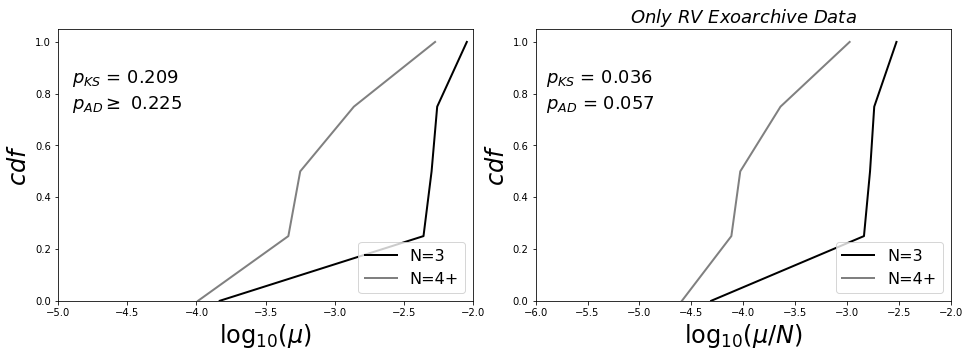

In [25]:
'''
Make mu cdf
Distinguish between N=3 and N=4+ systems

I included log(mu) and log(mu/N) to see if the dynamical mass of each system was somehow related to multiplicity.
'''

#mu cdf
fix, axes = plt.subplots(1, 2, figsize = (16, 5))

plt.subplots_adjust(wspace = 0.15)

ax = axes[0]

mu3 = logmu_final[N_final==3]
mu4 = logmu_final[N_final>=4]

mu3 = np.sort(np.squeeze(mu3))
mu4 = np.sort(np.squeeze(mu4))

ax.plot(mu3, np.linspace(0,1,len(mu3)), lw=2, color='black', label='N=3')
ax.plot(mu4, np.linspace(0,1,len(mu4)), lw=2, color='grey', label='N=4+')
ax.set_xlim(-5,-2)
ax.set_xlabel(r'$\log_{10}(\mu)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(mu3, mu4))
AD = stats.anderson_ksamp([mu3, mu4])[2]

ax.text(-4.9, 0.9, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-4.9, 0.8, r'$p_{AD} \geq$ %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')

plt.title(r'$Only\ RV\ Exoarchive\ Data$', fontsize=18)

ax = axes[1]

log_mu_over_N3 = log_mu_over_N[N_final==3]
log_mu_over_N4 = log_mu_over_N[N_final>=4]

log_mu_over_N3 = np.sort(np.squeeze(log_mu_over_N3))
log_mu_over_N4 = np.sort(np.squeeze(log_mu_over_N4))

ax.plot(log_mu_over_N3, np.linspace(0,1,len(log_mu_over_N3)), lw=2, color='black', label='N=3')
ax.plot(log_mu_over_N4, np.linspace(0,1,len(log_mu_over_N4)), lw=2, color='grey', label='N=4+')
ax.set_xlim(-6,-2)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

KS = np.array(stats.ks_2samp(log_mu_over_N3, log_mu_over_N4))
AD = stats.anderson_ksamp([log_mu_over_N3, log_mu_over_N4])[2]

ax.text(-5.9, 0.9, r'$p_{KS}$ = %.3f' %KS[1], fontsize = 18, ha = 'left', va = 'top')
ax.text(-5.9, 0.8, r'$p_{AD}$ = %.3f' %AD, fontsize = 18, ha = 'left', va = 'top')



plt.show()

# Take in dr_25 data

In [26]:
MAINPATH = 'C:/Users/djhoo/Documents/maiasaurus-master/'
cks_file = MAINPATH + 'catalogues/kepler_dr25.csv'                 #upload dr_25 data

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def get_key(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see first line
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname'] = get_key('kepoi_name')
for i in range(len(d['starname'])):
    d['starname'][i] = d['starname'][i][0:d['starname'][i].find('.')]
d['period'] = get_key('koi_period')
d['rprs'] = get_key('koi_ror')
d['impact'] = get_key('koi_impact')
d['koi_duration'] = get_key('koi_duration')
d['rp'] = get_key('koi_prad')
d['sma'] = get_key('koi_sma')
d['rstar'] = get_key('koi_srad')
d['mstar'] = get_key('koi_smass')
d['temp'] = get_key('koi_steff')
d['p'] = get_key('koi_period')
d['mag'] = get_key('koi_kepmag')

# QUICKLY CLEAN DATA

d0 = d.copy()
d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)

check_lengths(d)

def radius_mass(rp):
    '''
    If rp is an individual number, function will return an individual number for mp.
    If rp is a list, function will return a list for mp.
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2016).  This is kind of like the inverse of mass_radius above.
    '''
    if type(rp) != list:
        rp = float(rp)
        if rp < 1.23:
            mp = 10**((np.log10(rp)-0.00346)/0.2790)
        elif rp <= 11.1:
            mp = 10**((np.log10(rp)+0.0925)/0.589)
        elif rp >= 14.3:
            mp = 10**((np.log10(rp)+2.85)/0.881)
        else:
            mp = 0
    else:
        rp = np.array(rp).astype(float)
        mp = []
        for r in rp:
            if r < 1.23:
                mp.append(10**((np.log10(r)-0.00346)/0.2790))
            elif r <= 11.1:
                mp.append(10**((np.log10(r)+0.0925)/0.589))
            elif r >= 14.3:
                mp.append(10**((np.log10(r)+2.85)/0.881))
            else:
                mp.append(0)
        mp = np.array(mp).astype(float)
    return mp

d['mp'] = []
for i in range(len(d['rp'])):
    d['mp'].append(radius_mass(d['rp'][i]))

d = convert_floats(d)
    
print('after removing missing data, number of objects =', len(d['mp']))

total number of queried objects = 9564
after removing missing data, number of objects = 9199


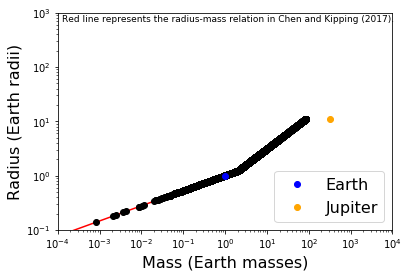

In [27]:
'''
Print masses and radii of each remaining planet to check if they are consistent.
'''
masses = np.array(d['mp'])
radii = np.array(d['rp'])

y = np.linspace(0.01, 1.23, 100).tolist()
x = radius_mass(y)
plt.plot(x, y, '-r')

y = np.linspace(1.23, 11.1, 100).tolist()
x = radius_mass(y)
plt.plot(x, y, '-g')

plt.plot(masses, radii, 'o', color='black')
                                                                              #add in Earth and Jupiter for reference
plt.plot(1, 1, 'o', color='blue', label='Earth')                                                 #Earth
plt.plot(MJUPITER/MEARTH, RJUPITER/REARTH, 'o', color='orange', label='Jupiter')                 #Jupiter

plt.xlabel('Mass (Earth masses)', fontsize=16)
plt.xscale("log")
plt.xlim(10**-4, 10**4)
plt.ylabel('Radius (Earth radii)', fontsize=16)
plt.yscale("log")
plt.ylim(10**-1, 10**3)
plt.text(10**-3.9, 700, 'Red line represents the radius-mass relation in Chen and Kipping (2017).', fontsize=9)

plt.legend(loc='lower right', fontsize=16)

plt.show()

In [28]:
for i in range(len(d['mstar'])):
    if mdwarf_mass_condition(d['mstar'][i]) == True and is_number(d['rp'][i]) and is_number(d['rstar'][i]) \
        and is_number(d['mp'][i]) and is_number(d['mstar'][i]) and is_number(d['p'][i]):
        mdwarves['rp'].append(d['rp'][i])
        mdwarves['rs'].append(d['rstar'][i])
        mdwarves['mp'].append(d['mp'][i])
        mdwarves['ms'].append(d['mstar'][i])
        mdwarves['p'].append(d['p'][i])
        mdwarves['detection_method'].append('Transit')
        mdwarves['starname'].append(d['starname'][i])

mdwarves['rp'] = convert_to_float(mdwarves['rp'])
mdwarves['rs'] = convert_to_float(mdwarves['rs'])
mdwarves['mp'] = convert_to_float(mdwarves['mp'])
mdwarves['ms'] = convert_to_float(mdwarves['ms'])
mdwarves['p'] = convert_to_float(mdwarves['p'])

In [29]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    
    # pull planetary data
    if stellar_mass_condition(s.Mstar) == True and len(d['mp'][d['starname']==us]) > 1:
        s.masses  = d['mp'][d['starname']==us]
        s.periods = d['period'][d['starname']==us]
    
        # sort masses, periods, and durations by period
        order = np.argsort(s.periods)
    
        s.masses  = s.masses[order]
        s.periods = s.periods[order]
    
    
        # calculate complexity measures (N, mu, Q, M, S, C, f)
        s.N  = len(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)

        s.Q  = archinfo.Q(s.masses)                            #we don't need flatness (yet)
        s.M  = archinfo.M(s.periods, s.masses)
        s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C  = archinfo.C(s.periods)
      
        systems.append(s)

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:186: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  co

In [30]:
Nsys = len(uniquesys)

'''
Any variable with the ending "_dr25" comes from the dr_25 data.
Any variable with the ending "_cks" comes from the CKS data.
'''

N_dr25  = np.zeros(Nsys)
mu_dr25 = np.zeros(Nsys)
Q_dr25  = np.zeros(Nsys)
M_dr25  = np.zeros(Nsys)
S_dr25  = np.zeros(Nsys)
C_dr25  = np.zeros(Nsys)
ms_dr25 = np.zeros(Nsys)

for i, s in enumerate(systems):
    N_dr25[i]  = s.N
    mu_dr25[i] = s.mu
    Q_dr25[i]  = s.Q
    M_dr25[i]  = s.M
    S_dr25[i]  = s.S
    C_dr25[i]  = s.C
    ms_dr25[i] = s.Mstar

logmu_dr25 = np.log10(mu_dr25)

mu_over_N_dr25 = []
for i in range(len(mu_dr25)):
    mu_over_N_dr25.append(mu_dr25[i]/N_dr25[i])

logmu_over_N_dr25 = np.log10(np.array(mu_over_N_dr25))

Q_dr25 = np.concatenate([Q_dr25, Q_transit])
logmu_dr25 = np.concatenate([logmu_dr25, logmu_transit])
logmu_over_N_dr25 = np.concatenate([logmu_over_N_dr25, logmuoverN_transit])
N_dr25 = np.concatenate([N_dr25, N_transit])
M_dr25 = np.concatenate([M_dr25, M_transit])
S_dr25 = np.concatenate([S_dr25, S_transit])
C_dr25 = np.concatenate([C_dr25, C_transit])
ms_dr25 = np.concatenate([ms_dr25, ms_transit])

ms_dr25 = ms_dr25[N_dr25>=3]
Q_dr25 = Q_dr25[N_dr25>=3]
M_dr25 = M_dr25[N_dr25>=3]
S_dr25 = S_dr25[N_dr25>=3]
C_dr25 = C_dr25[N_dr25>=3]
logmu_dr25 = logmu_dr25[N_dr25>=3]
logmu_over_N_dr25 = logmu_over_N_dr25[N_dr25>=3]
N_dr25 = N_dr25[N_dr25>=3]

Q_dr25 = Q_dr25[logmu_dr25 < -1]
M_dr25 = M_dr25[logmu_dr25 < -1]
S_dr25 = S_dr25[logmu_dr25 < -1]
C_dr25 = C_dr25[logmu_dr25 < -1]
logmu_over_N_dr25 = logmu_over_N_dr25[logmu_dr25 < -1]
ms_dr25 = ms_dr25[logmu_dr25 < -1]
N_dr25 = N_dr25[logmu_dr25 < -1]
logmu_dr25 = logmu_dr25[logmu_dr25 < -1]

"""
The following cdfs will represent systems of 3+ planets detected by
both the transit and RV technqiues.  The first 3 conditions from Fulton & Petigura (2018) are applied to both datasets.
"""

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


'\nThe following cdfs will represent systems of 3+ planets detected by\nboth the transit and RV technqiues.  The first 3 conditions from Fulton & Petigura (2018) are applied to both datasets.\n'

# Read in CKS data

In [31]:
cks_file = MAINPATH + 'catalogues/clean_kepler_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def get_key(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = get_key('id_starname')             # star id - 'K00082'
d['koi']         = get_key('id_koicand')
d['kic']         = get_key('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = get_key('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = get_key('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = get_key('koi_model_snr')           # transit signal-to-noise
d['npl']         = get_key('koi_count')               # number of planets in system

d['period']      = get_key('koi_period')              # period (days)
d['period_err1'] = get_key('koi_period_err1')
d['period_err2'] = get_key('koi_period_err2')

d['rprs']      = get_key('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = get_key('koi_ror_err1')
d['rprs_err2'] = get_key('koi_ror_err2')

d['impact']      = get_key('koi_impact')              # impact parameter
d['impact_err1'] = get_key('koi_impact_err1')
d['impact_err2'] = get_key('koi_impact_err2')

d['koi_duration']      = get_key('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = get_key('koi_duration_err1')
d['koi_duration_err2'] = get_key('koi_duration_err2')

d['rp']      = get_key('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = get_key('iso_prad_err1')
d['rp_err2'] = get_key('iso_prad_err2')

d['sma']      = get_key('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = get_key('iso_sma_err1')
d['sma_err2'] = get_key('iso_sma_err2')

d['rstar']      = get_key('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = get_key('iso_srad_err1')
d['rstar_err2'] = get_key('iso_srad_err2')

d['mstar']      = get_key('iso_smass')                # CKS+isochrone constrained stellar mass==== (solar mass)
d['mstar_err1'] = get_key('iso_smass_err1')
d['mstar_err2'] = get_key('iso_smass_err2')

d['temp'] = get_key('koi_steff')

d['mag'] = get_key('kic_kepmag')

d = convert_floats(d)

d['mp'] = np.load(MAINPATH + 'catalogues/cks_pred_masses_oct9.npy')[0]

In [32]:
for i in range(len(d['mstar'])):
    if mdwarf_mass_condition(d['mstar'][i]) == True and is_number(d['rp'][i]) and is_number(d['rstar'][i]) \
        and is_number(d['mp'][i]) and is_number(d['mstar'][i]) and is_number(d['period'][i]):
        mdwarves['rp'].append(d['rp'][i])
        mdwarves['rs'].append(d['rstar'][i])
        mdwarves['mp'].append(d['mp'][i])
        mdwarves['ms'].append(d['mstar'][i])
        mdwarves['p'].append(d['period'][i])
        mdwarves['detection_method'].append('Transit')
        mdwarves['starname'].append(d['starname'][i])

mdwarves['rp'] = convert_to_float(mdwarves['rp'])
mdwarves['rs'] = convert_to_float(mdwarves['rs'])
mdwarves['mp'] = convert_to_float(mdwarves['mp'])
mdwarves['ms'] = convert_to_float(mdwarves['ms'])
mdwarves['p'] = convert_to_float(mdwarves['p'])

In [33]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    if stellar_mass_condition(s.Mstar) == True:
    
        # pull planetary data
        s.rprs    = d['rprs'][d['starname']==us]
        s.masses  = d['mp'][d['starname']==us]
        s.periods = d['period'][d['starname']==us]

        # pull transit durations and errors, convert hrs to days
        s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
        s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                         (d['koi_duration_err2'][d['starname']==s.sysid]))/24

        # sort masses, periods, and durations by period
        order = np.argsort(s.periods)

        s.rprs    = s.rprs[order]
        s.masses  = s.masses[order]
        s.periods = s.periods[order]
        s.dur     = s.dur[order]
        s.dur_err = s.dur_err[order]


        # calculate complexity measures (N, mu, Q, M, S, C, f)
        s.N  = len(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.Q  = archinfo.Q(s.masses)
        s.M  = archinfo.M(s.periods, s.masses)
        s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C  = archinfo.C(s.periods)
        s.f  = archinfo.f(s.periods, s.Mstar/s.Rstar**3, s.rprs, s.dur, s.dur_err)

        systems.append(s)

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:48: RuntimeWarning: invalid value encountered in sqrt
  term2  = (term2a - term2b*term2c)**(1/2)


In [34]:
Nsys = len(uniquesys)

N_cks  = np.zeros(Nsys)
mu_cks = np.zeros(Nsys)
Q_cks  = np.zeros(Nsys)
M_cks  = np.zeros(Nsys)
S_cks  = np.zeros(Nsys)
C_cks  = np.zeros(Nsys)
f_cks  = np.zeros(Nsys)
ms_cks = np.zeros(Nsys)

for i, s in enumerate(systems):
    N_cks[i]  = s.N
    mu_cks[i] = s.mu
    Q_cks[i]  = s.Q
    M_cks[i]  = s.M
    S_cks[i]  = s.S
    C_cks[i]  = s.C
    f_cks[i]  = s.f
    ms_cks[i] = s.Mstar

logmu_cks = np.log10(mu_cks)

mu_over_N_cks = []
for i in range(len(mu_cks)):
    mu_over_N_cks.append(mu_cks[i]/N_cks[i])
logmu_over_N_cks = np.log10(np.array(mu_over_N_cks))

mu_cks = mu_cks[N_cks>=3]
Q_cks = Q_cks[N_cks>=3]
M_cks = M_cks[N_cks>=3]
S_cks = S_cks[N_cks>=3]
C_cks = C_cks[N_cks>=3]
f_cks = f_cks[N_cks>=3]
logmu_cks = logmu_cks[N_cks>=3]
logmu_over_N_cks = logmu_over_N_cks[N_cks>=3]
ms_cks = ms_cks[N_cks>=3]
N_cks = N_cks[N_cks>=3]

Q_cks = Q_cks[logmu_cks < -1]
M_cks = M_cks[logmu_cks < -1]
S_cks = S_cks[logmu_cks < -1]
C_cks = C_cks[logmu_cks < -1]
logmu_over_N_cks = logmu_over_N_cks[logmu_cks < -1]
ms_cks = ms_cks[logmu_cks < -1]
N_cks = N_cks[logmu_cks < -1]
logmu_cks = logmu_cks[logmu_cks < -1]

"""
The following cdfs will represent systems of 3+ planets subdivided into
CKS, dr_25, and RV data.  The first 3 conditions from Fulton & Petigura (2018) are applied to all datasets.
"""

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


'\nThe following cdfs will represent systems of 3+ planets subdivided into\nCKS, dr_25, and RV data.  The first 3 conditions from Fulton & Petigura (2018) are applied to all datasets.\n'

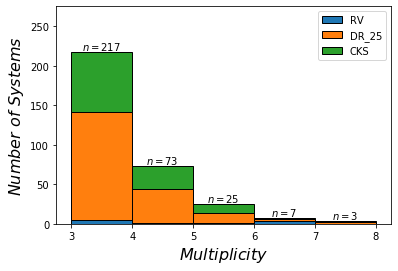

In [35]:
'''
Making a histogram of combined RV, CKS, DR_25 solar-mass star systems' multiplicities.
'''
plt.ylim(0, 275)
plt.ylabel(r'$Number\ of\ Systems$', fontsize=16)
plt.xlabel(r'$Multiplicity$', fontsize=16)               #making a histogram

N = np.array([[1, 2, 3], [1], [1, 2]])
N[0] = N_final
N[1] = N_dr25
N[2] = N_cks

plt.hist(N, bins = np.arange(3, 9, 1), edgecolor = 'k', histtype='bar', stacked=True, label=['RV', 'DR_25', 'CKS'])
plt.legend(loc='upper right')
for i in range(3, 8):
    plt.text(i+0.5, np.sum(N_final==i) + np.sum(N_dr25==i) + np.sum(N_cks==i), r'$n = %d$' %(np.sum(N_final==i) \
        + np.sum(N_dr25==i) + np.sum(N_cks==i)), va='bottom', ha='center', fontsize=10)
plt.xticks([3, 4, 5, 6, 7, 8])
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: p-value floored: true value smaller than 0.001
  if __name__ == '__main__':


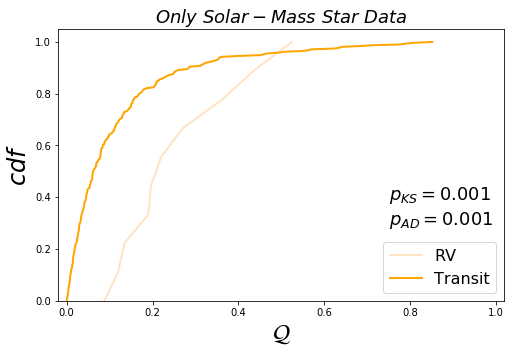

In [36]:
#Q cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

Q_rv = np.sort(np.squeeze(Q_final))
Q_transit = np.concatenate([Q_dr25, Q_cks])
Q_transit = np.sort(np.squeeze(Q_transit))

KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]


ax.plot(Q_rv, np.linspace(0,1,len(Q_rv)), lw=2, color='bisque', label='RV')
ax.plot(Q_transit, np.linspace(0,1,len(Q_transit)), lw=2, color='orange', label='Transit')

ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(0.75, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(0.75, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.title(r'$Only\ Solar-Mass\ Star\ Data$', fontsize=18)

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: p-value floored: true value smaller than 0.001
  if __name__ == '__main__':


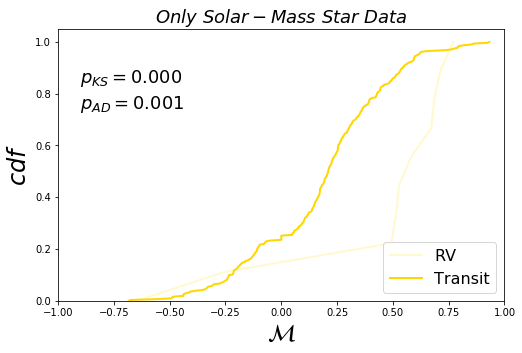

In [37]:
#M cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

M_rv = np.sort(np.squeeze(M_final))
M_transit = np.concatenate([M_dr25, M_cks])
M_transit = np.sort(np.squeeze(M_transit))

KS = np.array(stats.ks_2samp(M_rv, M_transit))[1]
AD = stats.anderson_ksamp([M_rv, M_transit])[2]

ax.plot(M_rv, np.linspace(0,1,len(M_rv)), lw=2, color='lemonchiffon', label='RV')
ax.plot(M_transit, np.linspace(0,1,len(M_transit)), lw=2, color='gold', label='Transit')
ax.set_xlim(-1,1)
ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(-0.9, 0.9, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(-0.9, 0.8, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

ax.legend(loc='lower right', fontsize=16)
plt.title(r'$Only\ Solar-Mass\ Star\ Data$', fontsize=18)

plt.show()

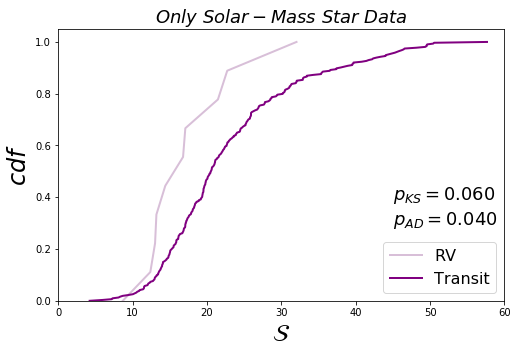

In [38]:
#S cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

S_rv = np.sort(np.squeeze(S_final))
S_transit = np.concatenate([S_dr25, S_cks])
S_transit = np.sort(np.squeeze(S_transit))

KS = np.array(stats.ks_2samp(S_rv, S_transit))[1]
AD = stats.anderson_ksamp([S_rv, S_transit])[2]


ax.plot(S_rv, np.linspace(0,1,len(S_rv)), lw=2, color='thistle', label='RV')
ax.plot(S_transit, np.linspace(0,1,len(S_transit)), lw=2, color='purple', label='Transit')

ax.set_xlim(-0.02,60)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(45, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(45, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')


ax.legend(loc='lower right', fontsize=16)
plt.title(r'$Only\ Solar-Mass\ Star\ Data$', fontsize=18)

plt.show()

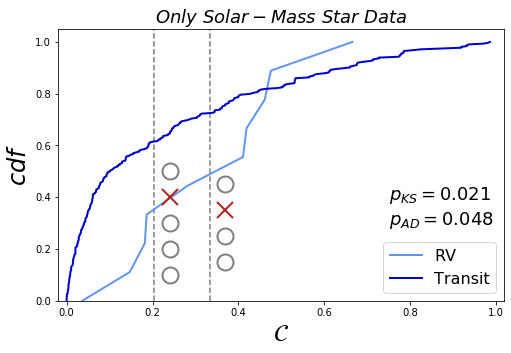

In [39]:
#C cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))

C_rv = np.sort(np.squeeze(C_final))
C_transit = np.concatenate([C_dr25, C_cks])
C_transit = np.sort(np.squeeze(C_transit))

KS = np.array(stats.ks_2samp(C_rv, C_transit))[1]
AD = stats.anderson_ksamp([C_rv, C_transit])[2]

ax.plot(C_rv, np.linspace(0,1,len(C_rv)), lw=2, color='cornflowerblue', label='RV')
ax.plot(C_transit, np.linspace(0,1,len(C_transit)), lw=2, color='mediumblue', label='Transit')

ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

ax.text(0.75, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(0.75, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.title(r'$Only\ Solar-Mass\ Star\ Data$', fontsize=18)

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: p-value floored: true value smaller than 0.001
  del sys.path[0]
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: p-value floored: true value smaller than 0.001


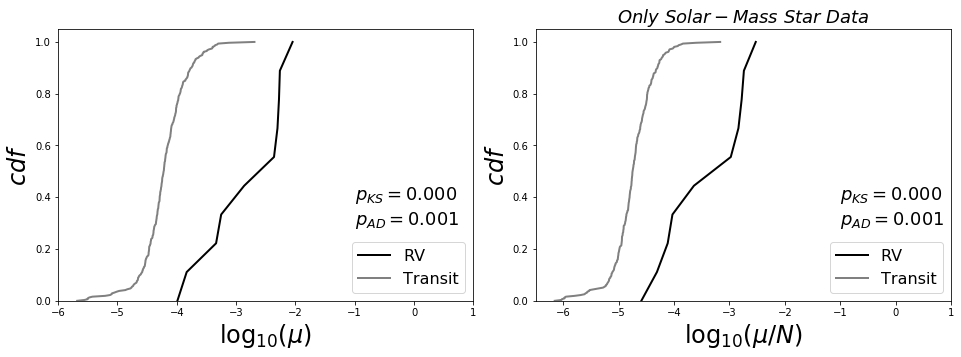

In [40]:
#mu cdf between RV and transit
fix, axes = plt.subplots(1, 2, figsize = (16, 5))

plt.subplots_adjust(wspace = 0.15)

ax = axes[0]

logmu_rv = np.sort(np.squeeze(logmu_final))
logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
logmu_transit = np.sort(np.squeeze(logmu_transit))

KS = np.array(stats.ks_2samp(logmu_rv, logmu_transit))[1]
AD = stats.anderson_ksamp([logmu_rv, logmu_transit])[2]

ax.plot(logmu_rv, np.linspace(0,1,len(logmu_rv)), lw=2, color='black', label='RV')
ax.plot(logmu_transit, np.linspace(0,1,len(logmu_transit)), lw=2, color='grey', label='Transit')

ax.text(-1, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(-1, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

ax.set_xlim(-6,1)
ax.set_xlabel(r'$\log_{10}(\mu)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax = axes[1]

logmu_over_N_rv = np.sort(np.squeeze(log_mu_over_N))
logmu_over_N_transit = np.concatenate([logmu_over_N_dr25, logmu_over_N_cks])
logmu_over_N_transit = np.sort(np.squeeze(logmu_over_N_transit))

KS = np.array(stats.ks_2samp(logmu_over_N_rv, logmu_over_N_transit))[1]
AD = stats.anderson_ksamp([logmu_over_N_rv, logmu_over_N_transit])[2]

ax.plot(logmu_over_N_rv, np.linspace(0,1,len(logmu_over_N_rv)), lw=2, color='black', label='RV')
ax.plot(logmu_over_N_transit, np.linspace(0,1,len(logmu_over_N_transit)), lw=2, color='grey', label='Transit')

ax.set_xlim(-6.5,1)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(-1, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(-1, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

ax.legend(loc='lower right', fontsize=16)
plt.title(r'$Only\ Solar-Mass\ Star\ Data$', fontsize=18)

plt.show()


In [41]:
uniquesys = np.unique(mdwarves['starname'])
systems = []

mdwarves = convert_floats(mdwarves)

for us in uniquesys:
    s = System()
    s.sysid = us
    s.Mstar = mdwarves['ms'][mdwarves['starname']==us][0]
    if len(mdwarves['mp'][mdwarves['starname']==us]) > 1:
        s.masses = np.array(mdwarves['mp'][mdwarves['starname']==us])
        s.periods = np.array(mdwarves['p'][mdwarves['starname']==us])
        s.detection_methods = mdwarves['detection_method'][mdwarves['starname']==us]

        order = np.argsort(s.periods)

        s.masses = s.masses[order]
        s.periods = s.periods[order]
        s.detection_methods = s.detection_methods[order]

        s.N = len(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.Q = archinfo.Q(s.masses)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)
        s.logmu_over_N = np.log10(s.mu/s.N)

        systems.append(s)

Nsys = len(uniquesys)

N_mdwarves  = np.zeros(Nsys)
mu_mdwarves = np.zeros(Nsys)
Q_mdwarves  = np.zeros(Nsys)
M_mdwarves  = np.zeros(Nsys)
S_mdwarves  = np.zeros(Nsys)
C_mdwarves  = np.zeros(Nsys)
logmu_over_N_mdwarves = np.zeros(Nsys)
ms_mdwarves = np.zeros(Nsys)
detection_methods_mdwarves = []

for i, s in enumerate(systems):
    N_mdwarves[i]  = s.N
    mu_mdwarves[i] = s.mu
    Q_mdwarves[i]  = s.Q
    M_mdwarves[i]  = s.M
    S_mdwarves[i]  = s.S
    C_mdwarves[i]  = s.C
    logmu_over_N_mdwarves[i] = s.logmu_over_N
    ms_mdwarves[i] = s.Mstar
    detection_methods_mdwarves.append(s.detection_methods)
    
logmu_mdwarves = np.log10(mu_mdwarves)

mu_mdwarves = mu_mdwarves[N_mdwarves >= 3]
logmu_mdwarves = logmu_mdwarves[N_mdwarves >= 3]
logmu_over_N_mdwarves = logmu_over_N_mdwarves[N_mdwarves >= 3]
Q_mdwarves  = Q_mdwarves[N_mdwarves >= 3]
M_mdwarves  = M_mdwarves[N_mdwarves >= 3]
S_mdwarves  = S_mdwarves[N_mdwarves >= 3]
C_mdwarves  = C_mdwarves[N_mdwarves >= 3]
ms_mdwarves = ms_mdwarves[N_mdwarves >= 3]
N_mdwarves  = N_mdwarves[N_mdwarves >= 3]

Q_mdwarves = Q_mdwarves[logmu_mdwarves < -1]
M_mdwarves = M_mdwarves[logmu_mdwarves < -1]
S_mdwarves = S_mdwarves[logmu_mdwarves < -1]
C_mdwarves = C_mdwarves[logmu_mdwarves < -1]
logmu_over_N_mdwarves = logmu_over_N_mdwarves[logmu_mdwarves < -1]
ms_mdwarves = ms_mdwarves[logmu_mdwarves < -1]
N_mdwarves = N_mdwarves[logmu_mdwarves < -1]
logmu_mdwarves = logmu_mdwarves[logmu_mdwarves < -1]

new_detection_methods = []
for arr in detection_methods_mdwarves:
    if len(arr) > 2:
        new_detection_methods.append(arr[0])
detection_methods_mdwarves = new_detection_methods

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


In [42]:
'''
Impose this condition in order to restrict the domains of the RV and transit population.
Remove all transit systems whose log(mu) < lowest log(mu) of all RV systems
'''

all_logmu_rv = []
for x in logmu_final:
    all_logmu_rv.append(x)
for i in range(len(detection_methods_mdwarves)):
    if detection_methods_mdwarves[i] == 'Radial Velocity':
        all_logmu_rv.append(logmu_mdwarves[i])
min_logmu = min(all_logmu_rv)

#dr25
Q_dr25 = Q_dr25[logmu_dr25 > min_logmu]
M_dr25 = M_dr25[logmu_dr25 > min_logmu]
S_dr25 = S_dr25[logmu_dr25 > min_logmu]
C_dr25 = C_dr25[logmu_dr25 > min_logmu]
N_dr25 = N_dr25[logmu_dr25 > min_logmu]
logmu_over_N_dr25 = logmu_over_N_dr25[logmu_dr25 > min_logmu]
ms_dr25 = ms_dr25[logmu_dr25 > min_logmu]
logmu_dr25 = logmu_dr25[logmu_dr25 > min_logmu]

#cks
Q_cks = Q_cks[logmu_cks > min_logmu]
M_cks = M_cks[logmu_cks > min_logmu]
S_cks = S_cks[logmu_cks > min_logmu]
C_cks = C_cks[logmu_cks > min_logmu]
N_cks = N_cks[logmu_cks > min_logmu]
logmu_over_N_cks = logmu_over_N_cks[logmu_cks > min_logmu]
ms_cks = ms_cks[logmu_cks > min_logmu]
logmu_cks = logmu_cks[logmu_cks > min_logmu]

#mdwarves
i = 0
while i < len(detection_methods_mdwarves):
    if detection_methods_mdwarves[i] == 'Transit' and logmu_mdwarves[i] < min_logmu:
        Q_mdwarves = np.delete(Q_mdwarves, i)
        M_mdwarves = np.delete(M_mdwarves, i)
        S_mdwarves = np.delete(S_mdwarves, i)
        C_mdwarves = np.delete(C_mdwarves, i)
        N_mdwarves = np.delete(N_mdwarves, i)
        logmu_over_N_mdwarves = np.delete(logmu_over_N_mdwarves, i)
        ms_mdwarves = np.delete(ms_mdwarves, i)
        logmu_mdwarves = np.delete(logmu_mdwarves, i)
        del detection_methods_mdwarves[i]
    else:
        i = i + 1
        
'''
Impose this condition in order to restrict the domains of the RV and transit population.
Remove all RV systems whose log(mu) > highest log(mu) of all transit systems
'''

all_logmu_transit = []
for x in logmu_dr25:
    all_logmu_transit.append(x)
for x in logmu_cks:
    all_logmu_transit.append(x)
for i in range(len(detection_methods_mdwarves)):
    if detection_methods_mdwarves[i] == 'Transit':
        all_logmu_transit.append(logmu_mdwarves[i])
max_logmu = max(all_logmu_transit)

#final
Q_final = Q_final[logmu_final < max_logmu]
M_final = M_final[logmu_final < max_logmu]
S_final = S_final[logmu_final < max_logmu]
C_final = C_final[logmu_final < max_logmu]
N_final = N_final[logmu_final < max_logmu]
log_mu_over_N = log_mu_over_N[logmu_final < max_logmu]
x = []
for arr in ms_final:
    x.append(arr[0])
ms_final = np.array(x)
ms_final = ms_final[logmu_final < max_logmu]
logmu_final = logmu_final[logmu_final < max_logmu]

#mdwarves
i = 0
while i < len(detection_methods_mdwarves):
    if detection_methods_mdwarves[i] == 'Radial Velocity' and logmu_mdwarves[i] > max_logmu:
        Q_mdwarves = np.delete(Q_mdwarves, i)
        M_mdwarves = np.delete(M_mdwarves, i)
        S_mdwarves = np.delete(S_mdwarves, i)
        C_mdwarves = np.delete(C_mdwarves, i)
        N_mdwarves = np.delete(N_mdwarves, i)
        logmu_over_N_mdwarves = np.delete(logmu_over_N_mdwarves, i)
        ms_mdwarves = np.delete(ms_mdwarves, i)
        logmu_mdwarves = np.delete(logmu_mdwarves, i)
        del detection_methods_mdwarves[i]
    else:
        i = i + 1


# Generate Switches

In [43]:
switch1 = 'separate'                  #either separate scatter plots by detection method or merge them together
#either 'together' or 'separate'

switch2 = 'both'                  #used to regulate type of stellar population
#either 'solar' or 'low' or 'both'

# Mass Partitioning, Q

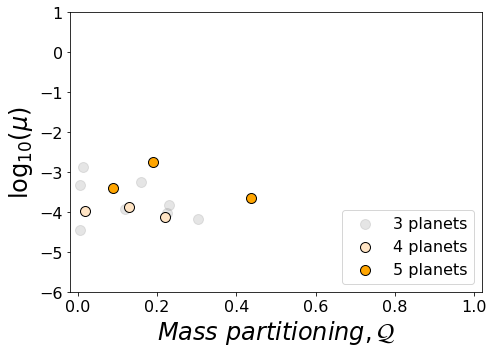

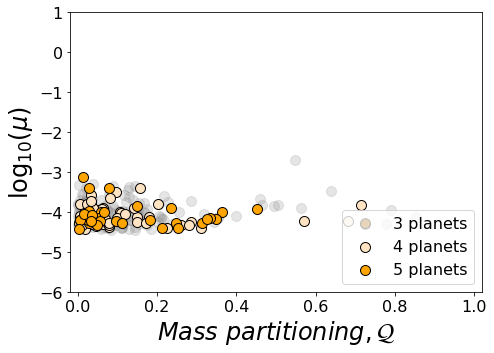

In [44]:
if switch2 == 'solar':
    Q_rv = Q_final
    Q_transit = np.concatenate([Q_dr25, Q_cks])
    logmu_rv = logmu_final
    logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
    N_rv = N_final
    N_transit = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        Q = np.concatenate([Q_rv, Q_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(Q[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q[N>=5], logmu[N>=5], c='orange', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q, Q])).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(Q, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax1h.plot(x, y, c='#ff8800', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(Q_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(Q_rv[N_rv==4], logmu_rv[N_rv==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax0.scatter(Q_rv[N_rv>=5], logmu_rv[N_rv>=5], c='orange', edgecolor='k', s=100, label='5+ planets')
        
        ax0.set_xlim(-0.02,1.02)
        ax0.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(Q_rv)).evaluate(x)
        ax0h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax0h.hist(Q_rv, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax0h.plot(x, y, c='#ff8800', lw=3)
        ax0h.set_xlim(-0.02, 1.02)
        ax0h.set_yticks([])
        ax0h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(Q_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(Q_transit[N_transit==4], logmu_transit[N_transit==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q_transit[N_transit>=5], logmu_transit[N_transit>=5], c='orange', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q_transit, Q_transit])).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(Q_transit, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax1h.plot(x, y, c='#ff8800', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)

        ax1h=plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])

                
elif switch2 == 'low':         #low-mass star systems
    Q_transit = []
    Q_rv = []
    N_transit = []
    N_rv = []
    logmu_transit = []
    logmu_rv = []
    for i in range(len(Q_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            Q_transit.append(Q_mdwarves[i])
            N_transit.append(N_mdwarves[i])
            logmu_transit.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            Q_rv.append(Q_mdwarves[i])
            N_rv.append(N_mdwarves[i])
            logmu_rv.append(logmu_mdwarves[i])
    Q_transit = np.array(Q_transit)
    Q_rv = np.array(Q_rv)
    N_transit = np.array(N_transit)
    N_rv = np.array(N_rv)
    logmu_transit = np.array(logmu_transit)
    logmu_rv = np.array(logmu_rv)
    if switch1=='together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        Q = np.concatenate([Q_rv, Q_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(Q[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q[N>=5], logmu[N>=5], c='orange', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q, Q])).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(Q, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax1h.plot(x, y, c='#ff8800', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
    
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(Q_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(Q_rv[N_rv>=4], logmu_rv[N_rv>=4], c='bisque', edgecolor='k', s=100, label='4 planets')
        
        ax0.set_xlim(-0.02,1.02)
        ax0.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q_rv,Q_rv])).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(Q_rv, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax1h.plot(x, y, c='#ff8800', lw=3)
        ax1h.set_xlim(-0.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(Q_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(Q_transit[N_transit==4], logmu_transit[N_transit==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q_transit[N_transit>=5], logmu_transit[N_transit>=5], c='orange', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q_transit, Q_transit])).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(Q_transit, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
        ax1h.plot(x, y, c='#ff8800', lw=3)
        ax1h.set_xlim(-0.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)

else:
    Q_transit_mdwarves = []
    Q_rv_mdwarves = []
    N_transit_mdwarves = []
    N_rv_mdwarves = []
    logmu_transit_mdwarves = []
    logmu_rv_mdwarves = []
    for i in range(len(Q_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            Q_transit_mdwarves.append(Q_mdwarves[i])
            N_transit_mdwarves.append(N_mdwarves[i])
            logmu_transit_mdwarves.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            Q_rv_mdwarves.append(Q_mdwarves[i])
            N_rv_mdwarves.append(N_mdwarves[i])
            logmu_rv_mdwarves.append(logmu_mdwarves[i])
    Q_transit_mdwarves = np.array(Q_transit_mdwarves)
    Q_rv_mdwarves = np.array(Q_rv_mdwarves)
    N_transit_mdwarves = np.array(N_transit_mdwarves)
    N_rv_mdwarves = np.array(N_rv_mdwarves)
    logmu_transit_mdwarves = np.array(logmu_transit_mdwarves)
    logmu_rv_mdwarves = np.array(logmu_rv_mdwarves)
    
    Q_rv_solar = Q_final
    Q_transit_solar = np.concatenate([Q_dr25, Q_cks])
    logmu_rv_solar = logmu_final
    logmu_transit_solar = np.concatenate([logmu_dr25, logmu_cks])
    N_rv_solar = N_final
    N_transit_solar = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        Q = np.concatenate([Q_rv_solar, Q_rv_mdwarves, Q_transit_mdwarves, Q_transit_solar])
        logmu = np.concatenate([logmu_transit_mdwarves, logmu_rv_mdwarves, logmu_rv_solar, logmu_transit_solar])
        N = np.concatenate([N_transit_mdwarves, N_rv_mdwarves, N_rv_solar, N_transit_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(Q[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q[N>=5], logmu[N>=5], c='orange', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
    else:
        Q_rv = np.concatenate([Q_rv_solar, Q_rv_mdwarves])
        Q_transit = np.concatenate([Q_transit_solar, Q_transit_mdwarves])
        N_rv = np.concatenate([N_rv_solar, N_rv_mdwarves])
        N_transit = np.concatenate([N_transit_solar, N_transit_mdwarves])
        logmu_transit= np.concatenate([logmu_transit_mdwarves, logmu_transit_solar])
        logmu_rv = np.concatenate([logmu_rv_mdwarves, logmu_rv_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(Q_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(Q_rv[N_rv==4], logmu_rv[N_rv==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(Q_rv[N_rv>=5], logmu_rv[N_rv>=5], c='orange', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax2 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax2.scatter(Q_transit[N_transit==3], logmu_transit[N_transit==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax2.scatter(Q_transit[N_transit==4], logmu_transit[N_transit==4], c='bisque', edgecolor='k', s=100, label='4 planets')
        ax2.scatter(Q_transit[N_transit>=5], logmu_transit[N_transit>=5], c='orange', edgecolor='k', s=100, label='5 planets')
        ax2.set_xlim(-0.02,1.02)
        ax2.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
        ax2.set_ylim(-6,1)
        ax2.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax2.legend(loc='lower right', frameon=True, fontsize=16)
        ax2.tick_params(labelsize=16)
        
        
    
        
plt.show()

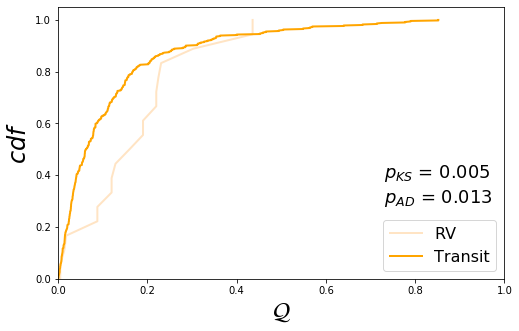

In [45]:
if switch2 == 'solar':
    Q_rv = Q_final
    Q_transit = np.concatenate([Q_dr25, Q_cks])
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q_rv = np.sort(np.squeeze(Q_rv))
        Q_transit = np.sort(np.squeeze(Q_transit))
        KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
        AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]
        ax.plot(Q_rv, np.linspace(0, 1, len(Q_rv)), lw=2, color='bisque', label='RV')
        ax.plot(Q_transit, np.linspace(0, 1, len(Q_transit)), lw=2, color='orange', label='Transit')
        ax.text(0.73, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(0.73, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q = np.concatenate([Q_rv, Q_transit])
        Q = np.sort(np.squeeze(Q))
        ax.plot(Q, np.linspace(0, 1, len(Q)), lw=2, color='orange', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
elif switch2 == 'low':
    Q_transit = []
    Q_rv = []
    for i in range(len(Q_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            Q_transit.append(Q_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            Q_rv.append(Q_mdwarves[i])
    Q_transit = np.array(Q_transit)
    Q_rv = np.array(Q_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q_rv = np.sort(np.squeeze(Q_rv))
        Q_transit = np.sort(np.squeeze(Q_transit))
        KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
        AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]
        ax.plot(Q_rv, np.linspace(0, 1, len(Q_rv)), lw=2, color='bisque', label='RV')
        ax.plot(Q_transit, np.linspace(0, 1, len(Q_transit)), lw=2, color='orange', label='Transit')
        ax.text(0.73, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(0.73, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q = np.concatenate([Q_rv, Q_transit])
        Q = np.sort(np.squeeze(Q))
        ax.plot(Q, np.linspace(0, 1, len(Q)), lw=2, color='orange', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
else:
    Q_rv_solar = Q_final
    Q_transit_solar = np.concatenate([Q_dr25, Q_cks])
    Q_transit_low = []
    Q_rv_low = []
    for i in range(len(Q_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            Q_transit_low.append(Q_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            Q_rv_low.append(Q_mdwarves[i])
    Q_transit_low = np.array(Q_transit)
    Q_rv_low = np.array(Q_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q_rv = np.concatenate([Q_rv_low, Q_rv_solar])
        Q_transit = np.concatenate([Q_transit_low, Q_transit_solar])
        Q_rv = np.sort(np.squeeze(Q_rv))
        Q_transit = np.sort(np.squeeze(Q_transit))
        KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
        AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]
        ax.plot(Q_rv, np.linspace(0, 1, len(Q_rv)), lw=2, color='bisque', label='RV')
        ax.plot(Q_transit, np.linspace(0, 1, len(Q_transit)), lw=2, color='orange', label='Transit')
        ax.text(0.73, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(0.73, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        Q = np.concatenate([Q_rv_low, Q_transit_low, Q_rv_solar, Q_transit_solar])
        Q = np.sort(np.squeeze(Q))
        ax.plot(Q, np.linspace(0, 1, len(Q)), lw=2, color='orange', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
plt.show()
        

# Monotonicity, M

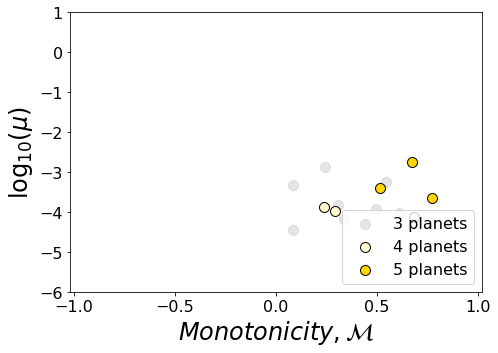

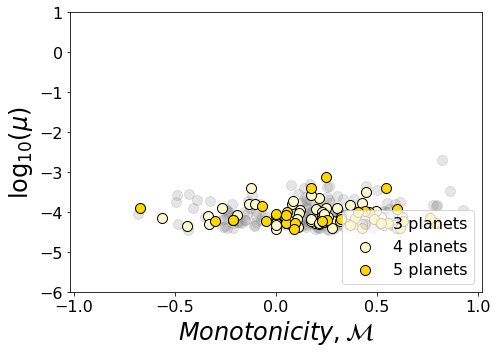

In [46]:
if switch2 == 'solar':
    M_rv = M_final
    M_transit = np.concatenate([M_dr25, M_cks])
    logmu_rv = logmu_final
    logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
    N_rv = N_final
    N_transit = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        M = np.concatenate([M_rv, M_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(M[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M[N>=5], logmu[N>=5], c='gold', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(M, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax1h.plot(x, y, c='#fcba03', lw=3)
        ax1h.set_xlim(-1.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(M_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(M_rv[N_rv==4], logmu_rv[N_rv==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax0.scatter(M_rv[N_rv>=5], logmu_rv[N_rv>=5], c='gold', edgecolor='k', s=100, label='5+ planets')
        
        ax0.set_xlim(-1.02,1.02)
        ax0.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_rv)).evaluate(x)
        ax0h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax0h.hist(M_rv, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax0h.plot(x, y, c='#fcba03', lw=3)
        ax0h.set_xlim(-1.02, 1.02)
        ax0h.set_yticks([])
        ax0h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(M_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(M_transit[N_transit==4], logmu_transit[N_transit==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M_transit[N_transit>=5], logmu_transit[N_transit>=5], c='gold', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(M_transit, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax1h.plot(x, y, c='#fcba08', lw=3)
        ax1h.set_xlim(-1.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        ax1h=plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])

                
elif switch2 == 'low':         #low-mass star systems
    M_transit = []
    M_rv = []
    N_transit = []
    N_rv = []
    logmu_transit = []
    logmu_rv = []
    for i in range(len(M_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            M_transit.append(M_mdwarves[i])
            N_transit.append(N_mdwarves[i])
            logmu_transit.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            M_rv.append(M_mdwarves[i])
            N_rv.append(N_mdwarves[i])
            logmu_rv.append(logmu_mdwarves[i])
    M_transit = np.array(M_transit)
    M_rv = np.array(M_rv)
    N_transit = np.array(N_transit)
    N_rv = np.array(N_rv)
    logmu_transit = np.array(logmu_transit)
    logmu_rv = np.array(logmu_rv)
    if switch1=='together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        M = np.concatenate([M_rv, M_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(M[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M[N>=5], logmu[N>=5], c='gold', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(M, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax1h.plot(x, y, c='#fcba08', lw=3)
        ax1h.set_xlim(-1.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
    
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(M_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(M_rv[N_rv>=4], logmu_rv[N_rv>=4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        
        ax0.set_xlim(-1.02,1.02)
        ax0.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_rv)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(M_rv, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax1h.plot(x, y, c='#fcba08', lw=3)
        ax1h.set_xlim(-1.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(M_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(M_transit[N_transit==4], logmu_transit[N_transit==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M_transit[N_transit>=5], logmu_transit[N_transit>=5], c='gold', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(M_transit, bins=np.arange(-1,1,0.05), density=True, color='lemonchiffon', edgecolor='k')
        ax1h.plot(x, y, c='#fcba08', lw=3)
        ax1h.set_xlim(-1.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
else:
    M_transit_mdwarves = []
    M_rv_mdwarves = []
    N_transit_mdwarves = []
    N_rv_mdwarves = []
    logmu_transit_mdwarves = []
    logmu_rv_mdwarves = []
    for i in range(len(M_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            M_transit_mdwarves.append(M_mdwarves[i])
            N_transit_mdwarves.append(N_mdwarves[i])
            logmu_transit_mdwarves.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            M_rv_mdwarves.append(M_mdwarves[i])
            N_rv_mdwarves.append(N_mdwarves[i])
            logmu_rv_mdwarves.append(logmu_mdwarves[i])
    M_transit_mdwarves = np.array(M_transit_mdwarves)
    M_rv_mdwarves = np.array(M_rv_mdwarves)
    N_transit_mdwarves = np.array(N_transit_mdwarves)
    N_rv_mdwarves = np.array(N_rv_mdwarves)
    logmu_transit_mdwarves = np.array(logmu_transit_mdwarves)
    logmu_rv_mdwarves = np.array(logmu_rv_mdwarves)
    
    M_rv_solar = M_final
    M_transit_solar = np.concatenate([M_dr25, M_cks])
    logmu_rv_solar = logmu_final
    logmu_transit_solar = np.concatenate([logmu_dr25, logmu_cks])
    N_rv_solar = N_final
    N_transit_solar = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        M = np.concatenate([M_rv_solar, M_rv_mdwarves, M_transit_mdwarves, M_transit_solar])
        logmu = np.concatenate([logmu_transit_mdwarves, logmu_rv_mdwarves, logmu_rv_solar, logmu_transit_solar])
        N = np.concatenate([N_transit_mdwarves, N_rv_mdwarves, N_rv_solar, N_transit_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(M[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M[N>=5], logmu[N>=5], c='gold', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
    else:
        M_rv = np.concatenate([M_rv_solar, M_rv_mdwarves])
        M_transit = np.concatenate([M_transit_solar, M_transit_mdwarves])
        N_rv = np.concatenate([N_rv_solar, N_rv_mdwarves])
        N_transit = np.concatenate([N_transit_solar, N_transit_mdwarves])
        logmu_transit= np.concatenate([logmu_transit_mdwarves, logmu_transit_solar])
        logmu_rv = np.concatenate([logmu_rv_mdwarves, logmu_rv_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(M_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(M_rv[N_rv==4], logmu_rv[N_rv==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(M_rv[N_rv>=5], logmu_rv[N_rv>=5], c='gold', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-1.02,1.02)
        ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax2 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax2.scatter(M_transit[N_transit==3], logmu_transit[N_transit==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax2.scatter(M_transit[N_transit==4], logmu_transit[N_transit==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
        ax2.scatter(M_transit[N_transit>=5], logmu_transit[N_transit>=5], c='gold', edgecolor='k', s=100, label='5 planets')
        ax2.set_xlim(-1.02,1.02)
        ax2.set_xlabel(r'$Monotonicity, \mathcal{M}$',fontsize=24)
        ax2.set_ylim(-6,1)
        ax2.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax2.legend(loc='lower right', frameon=True, fontsize=16)
        ax2.tick_params(labelsize=16)
    
        
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: p-value floored: true value smaller than 0.001


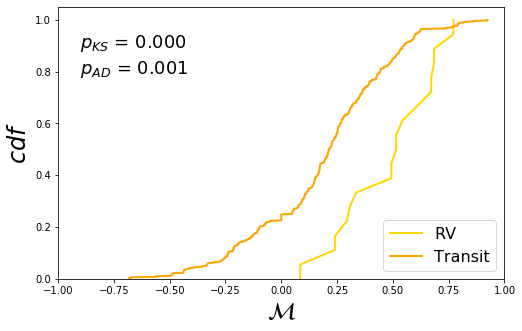

In [47]:
if switch2 == 'solar':
    M_rv = M_final
    M_transit = np.concatenate([M_dr25, M_cks])
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        M_rv = np.sort(np.squeeze(M_rv))
        M_transit = np.sort(np.squeeze(M_transit))
        ax.plot(M_rv, np.linspace(0, 1, len(M_rv)), lw=2, color='gold', label='RV')
        ax.plot(M_transit, np.linspace(0, 1, len(M_transit)), lw=2, color='orange', label='Transit')
        ax.set_xlim(-1.05, 1.05)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        M = np.concatenate([M_rv, M_transit])
        M = np.sort(np.squeeze(M))
        ax.plot(M, np.linspace(0, 1, len(M)), lw=2, color='gold', label='RV + Transit')
        ax.set_xlim(-1.05, 1.05)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
elif switch2 == 'low':
    M_transit = []
    M_rv = []
    for i in range(len(M_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            M_transit.append(M_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            M_rv.append(M_mdwarves[i])
    M_transit = np.array(M_transit)
    M_rv = np.array(M_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        M_rv = np.sort(np.squeeze(M_rv))
        M_transit = np.sort(np.squeeze(M_transit))
        ax.plot(M_rv, np.linspace(0, 1, len(M_rv)), lw=2, color='gold', label='RV')
        ax.plot(M_transit, np.linspace(0, 1, len(M_transit)), lw=2, color='orange', label='Transit')
        ax.set_xlim(-1.05, 1.05)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        M = np.concatenate([M_rv, M_transit])
        M = np.sort(np.squeeze(M))
        ax.plot(M, np.linspace(0, 1, len(M)), lw=2, color='gold', label='RV + Transit')
        ax.set_xlim(-1.05, 1.05)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
else:
    M_rv_solar = M_final
    M_transit_solar = np.concatenate([M_dr25, M_cks])
    M_transit_low = []
    M_rv_low = []
    for i in range(len(M_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            M_transit_low.append(M_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            M_rv_low.append(M_mdwarves[i])
    M_transit_low = np.array(M_transit)
    M_rv_low = np.array(M_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        M_rv = np.concatenate([M_rv_low, M_rv_solar])
        M_transit = np.concatenate([M_transit_low, M_transit_solar])
        M_rv = np.sort(np.squeeze(M_rv))
        M_transit = np.sort(np.squeeze(M_transit))
        KS = np.array(stats.ks_2samp(M_rv, M_transit))[1]
        AD = stats.anderson_ksamp([M_rv, M_transit])[2]
        ax.plot(M_rv, np.linspace(0, 1, len(M_rv)), lw=2, color='gold', label='RV')
        ax.plot(M_transit, np.linspace(0, 1, len(M_transit)), lw=2, color='orange', label='Transit')
        ax.text(-0.9, 0.95, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(-0.9, 0.85, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(-1, 1)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        M = np.concatenate([M_rv_low, M_transit_low, M_rv_solar, M_transit_solar])
        M = np.sort(np.squeeze(M))
        ax.plot(M, np.linspace(0, 1, len(M)), lw=2, color='gold', label='RV + Transit')
        ax.set_xlim(-1, 1)
        ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    
plt.show()

# Characteristic spacing, S

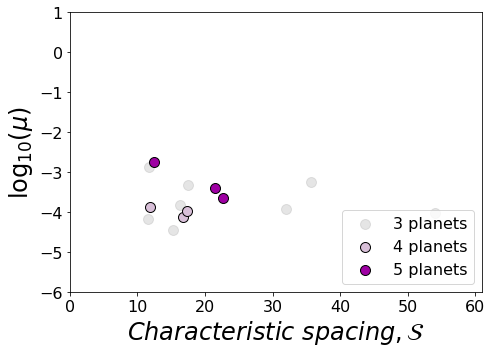

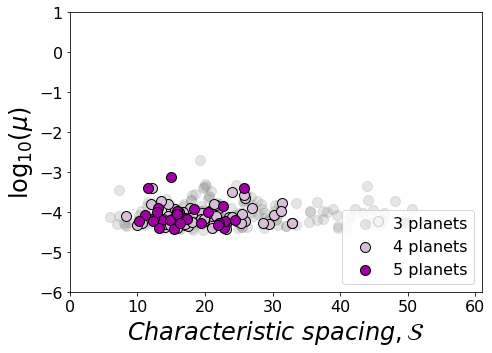

In [48]:
if switch2 == 'solar':
    S_rv = S_final
    S_transit = np.concatenate([S_dr25, S_cks])
    logmu_rv = logmu_final
    logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
    N_rv = N_final
    N_transit = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        S = np.concatenate([S_rv, S_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(S[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S[N>=5], logmu[N>=5], c=royalpurple, edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1, 61)
        ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(0, 60, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(S, bins=np.arange(0,61,1), density=True, color='thistle', edgecolor='k')
        ax1h.plot(x, y, c='indigo', lw=3)
        ax1h.set_xlim(-1, 61)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(S_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(S_rv[N_rv==4], logmu_rv[N_rv==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax0.scatter(S_rv[N_rv>=5], logmu_rv[N_rv>=5], c=royalpurple, edgecolor='k', s=100, label='5+ planets')
        
        ax0.set_xlim(-1,61)
        ax0.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(0, 60, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_rv)).evaluate(x)
        ax0h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax0h.hist(S_rv, bins=np.arange(0, 60, 1), density=True, color='thistle', edgecolor='k')
        ax0h.plot(x, y, c='indigo', lw=3)
        ax0h.set_xlim(-1, 61)
        ax0h.set_yticks([])
        ax0h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(S_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(S_transit[N_transit==4], logmu_transit[N_transit==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S_transit[N_transit>=5], logmu_transit[N_transit>=5], c=royalpurple, edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1,61)
        ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(0, 60, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(S_transit, bins=np.arange(0, 60, 1), density=True, color='thistle', edgecolor='k')
        ax1h.plot(x, y, c='indigo', lw=3)
        ax1h.set_xlim(-1, 61)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        ax1h=plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])

                
elif switch2 == 'low':         #low-mass star systems
    S_transit = []
    S_rv = []
    N_transit = []
    N_rv = []
    logmu_transit = []
    logmu_rv = []
    for i in range(len(S_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            S_transit.append(S_mdwarves[i])
            N_transit.append(N_mdwarves[i])
            logmu_transit.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            S_rv.append(S_mdwarves[i])
            N_rv.append(N_mdwarves[i])
            logmu_rv.append(logmu_mdwarves[i])
    S_transit = np.array(S_transit)
    S_rv = np.array(S_rv)
    N_transit = np.array(N_transit)
    N_rv = np.array(N_rv)
    logmu_transit = np.array(logmu_transit)
    logmu_rv = np.array(logmu_rv)
    if switch1=='together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        S = np.concatenate([S_rv, S_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(S[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S[N>=5], logmu[N>=5], c=royalpurple, edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1,61)
        ax1.set_xlabel(r'$Charactersitic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(0, 60, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(S, bins=np.arange(0, 60, 1), density=True, color='thistle', edgecolor='k')
        ax1h.plot(x, y, c='indigo', lw=3)
        ax1h.set_xlim(-1, 61)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
    
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(S_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(S_rv[N_rv>=4], logmu_rv[N_rv>=4], c='thistle', edgecolor='k', s=100, label='4 planets')
        
        ax0.set_xlim(-1,61)
        ax0.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(0,60,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_rv)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(S_rv, bins=np.arange(0, 60, 1), density=True, color='thistle', edgecolor='k')
        ax1h.plot(x, y, c='indigo', lw=3)
        ax1h.set_xlim(-1, 61)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(S_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(S_transit[N_transit==4], logmu_transit[N_transit==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S_transit[N_transit>=5], logmu_transit[N_transit>=5], c=royalpurple, edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-1,61)
        ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(0,60,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(S_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(S_transit, bins=np.arange(0, 60, 1), density=True, color='thistle', edgecolor='k')
        ax1h.plot(x, y, c='indigo', lw=3)
        ax1h.set_xlim(-1, 61)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
else:
    S_transit_mdwarves = []
    S_rv_mdwarves = []
    N_transit_mdwarves = []
    N_rv_mdwarves = []
    logmu_transit_mdwarves = []
    logmu_rv_mdwarves = []
    for i in range(len(S_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            S_transit_mdwarves.append(S_mdwarves[i])
            N_transit_mdwarves.append(N_mdwarves[i])
            logmu_transit_mdwarves.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            S_rv_mdwarves.append(S_mdwarves[i])
            N_rv_mdwarves.append(N_mdwarves[i])
            logmu_rv_mdwarves.append(logmu_mdwarves[i])
    S_transit_mdwarves = np.array(S_transit_mdwarves)
    S_rv_mdwarves = np.array(S_rv_mdwarves)
    N_transit_mdwarves = np.array(N_transit_mdwarves)
    N_rv_mdwarves = np.array(N_rv_mdwarves)
    logmu_transit_mdwarves = np.array(logmu_transit_mdwarves)
    logmu_rv_mdwarves = np.array(logmu_rv_mdwarves)
    
    S_rv_solar = S_final
    S_transit_solar = np.concatenate([S_dr25, S_cks])
    logmu_rv_solar = logmu_final
    logmu_transit_solar = np.concatenate([logmu_dr25, logmu_cks])
    N_rv_solar = N_final
    N_transit_solar = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        S = np.concatenate([S_rv_solar, S_rv_mdwarves, S_transit_mdwarves, S_transit_solar])
        logmu = np.concatenate([logmu_transit_mdwarves, logmu_rv_mdwarves, logmu_rv_solar, logmu_transit_solar])
        N = np.concatenate([N_transit_mdwarves, N_rv_mdwarves, N_rv_solar, N_transit_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(S[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S[N>=5], logmu[N>=5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(0,61)
        ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
    else:
        S_rv = np.concatenate([S_rv_solar, S_rv_mdwarves])
        S_transit = np.concatenate([S_transit_solar, S_transit_mdwarves])
        N_rv = np.concatenate([N_rv_solar, N_rv_mdwarves])
        N_transit = np.concatenate([N_transit_solar, N_transit_mdwarves])
        logmu_transit= np.concatenate([logmu_transit_mdwarves, logmu_transit_solar])
        logmu_rv = np.concatenate([logmu_rv_mdwarves, logmu_rv_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(S_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(S_rv[N_rv==4], logmu_rv[N_rv==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax1.scatter(S_rv[N_rv>=5], logmu_rv[N_rv>=5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(0,61)
        ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax2 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax2.scatter(S_transit[N_transit==3], logmu_transit[N_transit==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax2.scatter(S_transit[N_transit==4], logmu_transit[N_transit==4], c='thistle', edgecolor='k', s=100, label='4 planets')
        ax2.scatter(S_transit[N_transit>=5], logmu_transit[N_transit>=5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
        ax2.set_xlim(0,61)
        ax2.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$',fontsize=24)
        ax2.set_ylim(-6,1)
        ax2.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax2.legend(loc='lower right', frameon=True, fontsize=16)
        ax2.tick_params(labelsize=16)
        
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: p-value capped: true value larger than 0.25


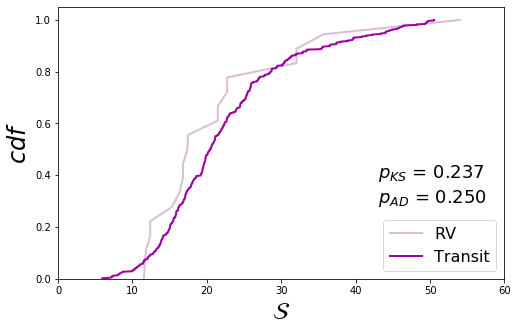

In [49]:
if switch2 == 'solar':
    S_rv = S_final
    S_transit = np.concatenate([S_dr25, S_cks])
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        S_rv = np.sort(np.squeeze(S_rv))
        S_transit = np.sort(np.squeeze(S_transit))
        ax.plot(S_rv, np.linspace(0, 1, len(S_rv)), lw=2, color='thistle', label='RV')
        ax.plot(S_transit, np.linspace(0, 1, len(S_transit)), lw=2, color=royalpurple, label='Transit')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        S = np.concatenate([S_rv, S_transit])
        S = np.sort(np.squeeze(S))
        ax.plot(S, np.linspace(0, 1, len(S)), lw=2, color='thistle', label='RV + Transit')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
elif switch2 == 'low':
    S_transit = []
    S_rv = []
    for i in range(len(S_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            S_transit.append(S_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            S_rv.append(S_mdwarves[i])
    S_transit = np.array(S_transit)
    S_rv = np.array(S_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        S_rv = np.sort(np.squeeze(S_rv))
        S_transit = np.sort(np.squeeze(S_transit))
        ax.plot(S_rv, np.linspace(0, 1, len(S_rv)), lw=2, color='thistle', label='RV')
        ax.plot(S_transit, np.linspace(0, 1, len(S_transit)), lw=2, color=royalpurple, label='Transit')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        S = np.concatenate([S_rv, S_transit])
        S = np.sort(np.squeeze(S))
        ax.plot(S, np.linspace(0, 1, len(S)), lw=2, color='thistle', label='RV + Transit')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
else:
    S_rv_solar = S_final
    S_transit_solar = np.concatenate([S_dr25, S_cks])
    S_transit_low = []
    S_rv_low = []
    for i in range(len(S_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            S_transit_low.append(S_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            S_rv_low.append(S_mdwarves[i])
    S_transit_low = np.array(S_transit)
    S_rv_low = np.array(S_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        S_rv = np.concatenate([S_rv_low, S_rv_solar])
        S_transit = np.concatenate([S_transit_low, S_transit_solar])
        S_rv = np.sort(np.squeeze(S_rv))
        S_transit = np.sort(np.squeeze(S_transit))
        KS = np.array(stats.ks_2samp(S_rv, S_transit))[1]
        AD = stats.anderson_ksamp([S_rv, S_transit])[2]
        ax.plot(S_rv, np.linspace(0, 1, len(S_rv)), lw=2, color='thistle', label='RV')
        ax.plot(S_transit, np.linspace(0, 1, len(S_transit)), lw=2, color=royalpurple, label='Transit')
        ax.text(43, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(43, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        S = np.concatenate([S_rv_low, S_transit_low, S_rv_solar, S_transit_solar])
        S = np.sort(np.squeeze(S))
        ax.plot(S, np.linspace(0, 1, len(S)), lw=2, color='thistle', label='RV + Transit')
        ax.set_xlim(0, 60)
        ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
plt.show()

# Gap complexity, C

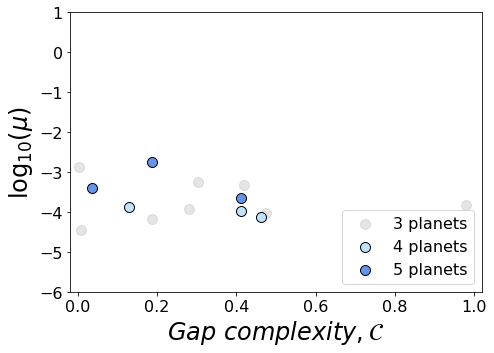

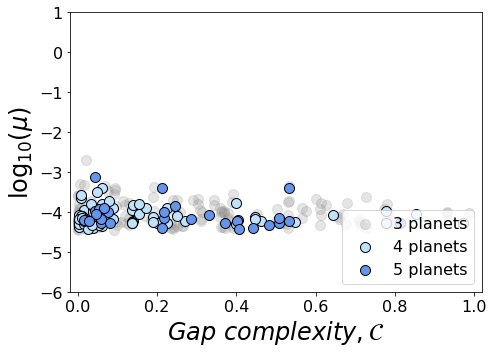

In [50]:
if switch2 == 'solar':
    C_rv = C_final
    C_transit = np.concatenate([C_dr25, C_cks])
    logmu_rv = logmu_final
    logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
    N_rv = N_final
    N_transit = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        C = np.concatenate([C_rv, C_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(C[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(C[N==4], logmu[N==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C[N>=5], logmu[N>=5], c='cornflowerblue', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(C, bins=np.arange(-1,1,0.05), density=True, color=robinseggblue, edgecolor='k')
        ax1h.plot(x, y, c='mediumblue', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(C_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(C_rv[N_rv==4], logmu_rv[N_rv==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax0.scatter(C_rv[N_rv>=5], logmu_rv[N_rv>=5], c='cornflowerblue', edgecolor='k', s=100, label='5+ planets')
        
        ax0.set_xlim(-0.02,1.02)
        ax0.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C_rv)).evaluate(x)
        ax0h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax0h.hist(C_rv, bins=np.arange(-1,1,0.05), density=True, color='cornflowerblue', edgecolor='k')
        ax0h.plot(x, y, c='mediumblue', lw=3)
        ax0h.set_xlim(-0.02, 1.02)
        ax0h.set_yticks([])
        ax0h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(C_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(C_transit[N_transit==4], logmu_transit[N_transit==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C_transit[N_transit>=5], logmu_transit[N_transit>=5], c='cornflowerblue', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(C_transit, bins=np.arange(-1,1,0.05), density=True, color='cornflowerblue', edgecolor='k')
        ax1h.plot(x, y, c='mediumblue', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-6, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        ax1h=plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        ax1h.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        ax1h.plot(y, x, lw=2, c='k')
        ax1h.set_yticks([])
        ax1h.set_ylim(-6,1)
        ax1h.set_xticks([])

                
elif switch2 == 'low':         #low-mass star systems
    C_transit = []
    C_rv = []
    N_transit = []
    N_rv = []
    logmu_transit = []
    logmu_rv = []
    for i in range(len(C_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            C_transit.append(C_mdwarves[i])
            N_transit.append(N_mdwarves[i])
            logmu_transit.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            C_rv.append(C_mdwarves[i])
            N_rv.append(N_mdwarves[i])
            logmu_rv.append(logmu_mdwarves[i])
    C_transit = np.array(C_transit)
    C_rv = np.array(C_rv)
    N_transit = np.array(N_transit)
    N_rv = np.array(N_rv)
    logmu_transit = np.array(logmu_transit)
    logmu_rv = np.array(logmu_rv)
    if switch1=='together':
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        
        C = np.concatenate([C_rv, C_transit])
        logmu = np.concatenate([logmu_rv, logmu_transit])
        N = np.concatenate([N_rv, N_transit])
        
        ax1.scatter(C[N==3], logmu[N==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(C[N==4], logmu[N==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C[N>=5], logmu[N>=5], c='cornflowerblue', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1, 1, 1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(C, bins=np.arange(-1,1,0.05), density=True, color='cornflowerblue', edgecolor='k')
        ax1h.plot(x, y, c='mediumblue', lw=3)
        ax1h.set_xlim(-0.02, 1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
    
    else:
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax0 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax0.scatter(C_rv[N_rv==3], logmu_rv[N_rv==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax0.scatter(C_rv[N_rv>=4], logmu_rv[N_rv>=4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        
        ax0.set_xlim(-0.02,1.02)
        ax0.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax0.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax0.set_ylim(-6, 1)
        ax0.legend(loc='lower right', frameon=True, fontsize=16)
        ax0.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C_rv)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(C_rv, bins=np.arange(-1,1,0.05), density=True, color='cornflowerblue', edgecolor='k')
        ax1h.plot(x, y, c='mediumblue', lw=3)
        ax1h.set_xlim(-0.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_rv).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_rv,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(C_transit[N_transit==3], logmu_transit[N_transit==3], c='grey', alpha=0.2, s=100, label='3 planets')
        ax1.scatter(C_transit[N_transit==4], logmu_transit[N_transit==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C_transit[N_transit>=5], logmu_transit[N_transit>=5], c='cornflowerblue', edgecolor='k', s=100, label='5+ planets')
        
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.set_ylim(-6, 1)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        x = np.linspace(-1,1,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(C_transit)).evaluate(x)
        ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
        ax1h.hist(C_transit, bins=np.arange(-1,1,0.05), density=True, color='cornflowerblue', edgecolor='k')
        ax1h.plot(x, y, c='mediumblue', lw=3)
        ax1h.set_xlim(-0.02,1.02)
        ax1h.set_yticks([])
        ax1h.tick_params(labelsize=16)
        
        x = np.linspace(-7,2,1000)
        y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu_transit).evaluate(x)
        axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
        axsh.hist(logmu_transit,bins=np.arange(-7,2,1), density=True, \
                 orientation='horizontal',color='lightgrey',edgecolor='black')
        axsh.plot(y, x, lw=2, c='k')
        axsh.set_yticks([])
        axsh.set_ylim(-6,1)
        axsh.set_xticks([])
        ax1h.tick_params(labelsize=16)
        
else:
    C_transit_mdwarves = []
    C_rv_mdwarves = []
    N_transit_mdwarves = []
    N_rv_mdwarves = []
    logmu_transit_mdwarves = []
    logmu_rv_mdwarves = []
    for i in range(len(C_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            C_transit_mdwarves.append(C_mdwarves[i])
            N_transit_mdwarves.append(N_mdwarves[i])
            logmu_transit_mdwarves.append(logmu_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            C_rv_mdwarves.append(C_mdwarves[i])
            N_rv_mdwarves.append(N_mdwarves[i])
            logmu_rv_mdwarves.append(logmu_mdwarves[i])
    C_transit_mdwarves = np.array(C_transit_mdwarves)
    C_rv_mdwarves = np.array(C_rv_mdwarves)
    N_transit_mdwarves = np.array(N_transit_mdwarves)
    N_rv_mdwarves = np.array(N_rv_mdwarves)
    logmu_transit_mdwarves = np.array(logmu_transit_mdwarves)
    logmu_rv_mdwarves = np.array(logmu_rv_mdwarves)
    
    C_rv_solar = C_final
    C_transit_solar = np.concatenate([C_dr25, C_cks])
    logmu_rv_solar = logmu_final
    logmu_transit_solar = np.concatenate([logmu_dr25, logmu_cks])
    N_rv_solar = N_final
    N_transit_solar = np.concatenate([N_dr25, N_cks])
    if switch1 == 'together':
        C = np.concatenate([C_rv_solar, C_rv_mdwarves, C_transit_mdwarves, C_transit_solar])
        logmu = np.concatenate([logmu_transit_mdwarves, logmu_rv_mdwarves, logmu_rv_solar, logmu_transit_solar])
        N = np.concatenate([N_transit_mdwarves, N_rv_mdwarves, N_rv_solar, N_transit_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(C[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(C[N==4], logmu[N==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C[N>=5], logmu[N>=5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
    else:
        C_rv = np.concatenate([C_rv_solar, C_rv_mdwarves])
        C_transit = np.concatenate([C_transit_solar, C_transit_mdwarves])
        N_rv = np.concatenate([N_rv_solar, N_rv_mdwarves])
        N_transit = np.concatenate([N_transit_solar, N_transit_mdwarves])
        logmu_transit= np.concatenate([logmu_transit_mdwarves, logmu_transit_solar])
        logmu_rv = np.concatenate([logmu_rv_mdwarves, logmu_rv_solar])
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax1.scatter(C_rv[N_rv==3], logmu_rv[N_rv==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax1.scatter(C_rv[N_rv==4], logmu_rv[N_rv==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax1.scatter(C_rv[N_rv>=5], logmu_rv[N_rv>=5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
        ax1.set_xlim(-0.02,1.02)
        ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax1.set_ylim(-6,1)
        ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax1.legend(loc='lower right', frameon=True, fontsize=16)
        ax1.tick_params(labelsize=16)
        
        plt.figure(figsize=(10,7))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        ax2 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ax2.scatter(C_transit[N_transit==3], logmu_transit[N_transit==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
        ax2.scatter(C_transit[N_transit==4], logmu_transit[N_transit==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
        ax2.scatter(C_transit[N_transit>=5], logmu_transit[N_transit>=5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
        ax2.set_xlim(-0.02,1.02)
        ax2.set_xlabel(r'$Gap\ complexity, \mathcal{C}$',fontsize=24)
        ax2.set_ylim(-6,1)
        ax2.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
        ax2.legend(loc='lower right', frameon=True, fontsize=16)
        ax2.tick_params(labelsize=16)
        
plt.show()

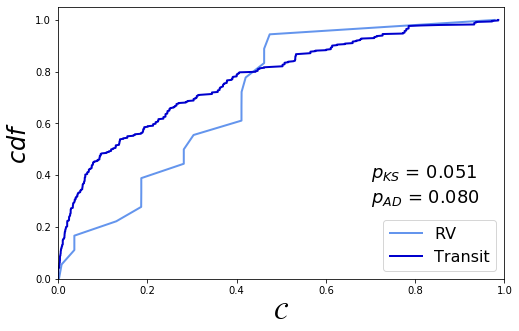

In [51]:
if switch2 == 'solar':
    C_rv = C_final
    C_transit = np.concatenate([C_dr25, C_cks])
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        C_rv = np.sort(np.squeeze(C_rv))
        C_transit = np.sort(np.squeeze(C_transit))
        ax.plot(C_rv, np.linspace(0, 1, len(C_rv)), lw=2, color='cornflowerblue', label='RV')
        ax.plot(C_transit, np.linspace(0, 1, len(C_transit)), lw=2, color='mediumblue', label='Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        C = np.concatenate([C_rv, C_transit])
        C = np.sort(np.squeeze(C))
        ax.plot(C, np.linspace(0, 1, len(C)), lw=2, color='cornflowerblue', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
elif switch2 == 'low':
    C_transit = []
    C_rv = []
    for i in range(len(C_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            C_transit.append(C_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            C_rv.append(C_mdwarves[i])
    C_transit = np.array(C_transit)
    C_rv = np.array(C_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        C_rv = np.sort(np.squeeze(C_rv))
        C_transit = np.sort(np.squeeze(C_transit))
        ax.plot(C_rv, np.linspace(0, 1, len(C_rv)), lw=2, color='cornflowerblue', label='RV')
        ax.plot(C_transit, np.linspace(0, 1, len(C_transit)), lw=2, color='mediumblue', label='Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        C = np.concatenate([C_rv, C_transit])
        C = np.sort(np.squeeze(C))
        ax.plot(C, np.linspace(0, 1, len(C)), lw=2, color='cornflowerblue', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
else:
    C_rv_solar = C_final
    C_transit_solar = np.concatenate([C_dr25, C_cks])
    C_transit_low = []
    C_rv_low = []
    for i in range(len(C_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            C_transit_low.append(C_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            C_rv_low.append(C_mdwarves[i])
    C_transit_low = np.array(C_transit)
    C_rv_low = np.array(C_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        C_rv = np.concatenate([C_rv_low, C_rv_solar])
        C_transit = np.concatenate([C_transit_low, C_transit_solar])
        C_rv = np.sort(np.squeeze(C_rv))
        C_transit = np.sort(np.squeeze(C_transit))
        KS = np.array(stats.ks_2samp(C_rv, C_transit))[1]
        AD = stats.anderson_ksamp([C_rv, C_transit])[2]
        ax.plot(C_rv, np.linspace(0, 1, len(C_rv)), lw=2, color='cornflowerblue', label='RV')
        ax.plot(C_transit, np.linspace(0, 1, len(C_transit)), lw=2, color='mediumblue', label='Transit')
        ax.text(0.7, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(0.7, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        C = np.concatenate([C_rv_low, C_transit_low, C_rv_solar, C_transit_solar])
        C = np.sort(np.squeeze(C))
        ax.plot(C, np.linspace(0, 1, len(C)), lw=2, color='cornflowerblue', label='RV + Transit')
        ax.set_xlim(0, 1)
        ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
plt.show()

# Dynamical mass, $\mu$

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:136: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:154: UserWarning: p-value floored: true value smaller than 0.001


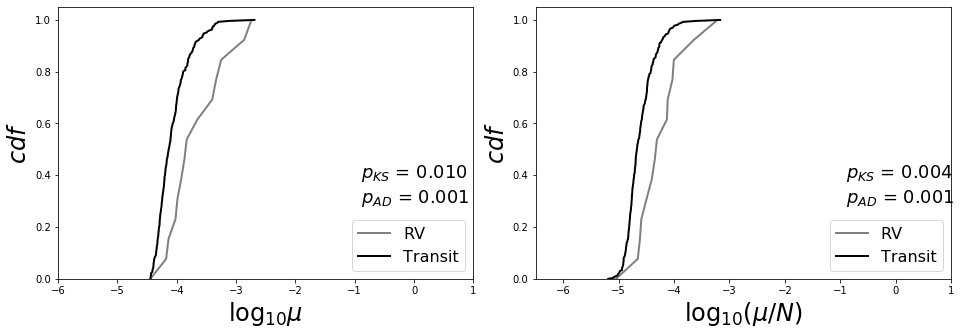

In [52]:
if switch2 == 'solar':
    logmu_rv = logmu_final
    logmu_transit = np.concatenate([logmu_dr25, logmu_cks])
    logmu_over_N_rv = log_mu_over_N
    logmu_over_N_transit = np.concatenate([logmu_over_N_dr25, logmu_over_N_cks])
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_rv = np.sort(np.squeeze(logmu_rv))
        logmu_transit = np.sort(np.squeeze(logmu_transit))
        ax.plot(logmu_rv, np.linspace(0, 1, len(logmu_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmu_transit, np.linspace(0, 1, len(logmu_transit)), lw=2, color='black', label='Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_over_N_rv = np.sort(np.squeeze(logmu_over_N_rv))
        logmu_over_N_transit = np.sort(np.squeeze(logmu_over_N_transit))
        ax.plot(logmu_over_N_rv, np.linspace(0, 1, len(logmu_over_N_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmu_over_N_transit, np.linspace(0, 1, len(logmu_over_N_transit)), lw=2, color='black', label='Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu = np.concatenate([logmu_rv, logmu_transit])
        logmu = np.sort(np.squeeze(logmu))
        ax.plot(logmu, np.linspace(0, 1, len(logmu)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_over_N = np.concatenate([logmu_over_N_rv, logmu_over_N_transit])
        logmu_over_N = np.sort(np.squeeze(logmu_over_N))
        ax.plot(logmu_over_N, np.linspace(0, 1, len(logmu_over_N)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
elif switch2 == 'low':
    logmu_transit = []
    logmu_rv = []
    logmu_over_N_transit = []
    logmu_over_N_rv = []
    for i in range(len(logmu_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            logmu_transit.append(logmu_mdwarves[i])
            logmu_over_N_transit.append(logmu_over_N_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            logmu_rv.append(logmu_mdwarves[i])
            logmu_over_N_rv.append(logmu_over_N_mdwarves[i])
    logmu_transit = np.array(logmu_transit)
    logmu_rv = np.array(logmu_rv)
    logmu_over_N_transit = np.array(logmu_over_N_transit)
    logmu_over_N_rv = np.array(logmu_over_N_rv)
    if switch1 == 'separate':
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_rv = np.sort(np.squeeze(logmu_rv))
        logmu_transit = np.sort(np.squeeze(logmu_transit))
        ax.plot(logmu_rv, np.linspace(0, 1, len(logmu_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmu_transit, np.linspace(0, 1, len(logmu_transit)), lw=2, color='black', label='Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_over_N_rv = np.sort(np.squeeze(logmu_over_N_rv))
        logmu_over_N_transit = np.sort(np.squeeze(logmu_over_N_transit))
        ax.plot(logmu_over_N_rv, np.linspace(0, 1, len(logmu_over_N_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmu_over_N_transit, np.linspace(0, 1, len(logmu_over_N_transit)), lw=2, color='black', label='Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
    else:
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu = np.concatenate([logmu_rv, logmu_transit])
        logmu = np.sort(np.squeeze(logmu))
        ax.plot(logmu, np.linspace(0, 1, len(logmu)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        fig, ax = plt.subplots(1, figsize=(8,5))
        logmu_over_N = np.concatenate([logmu_over_N_rv, logmu_over_N_transit])
        logmu_over_N = np.sort(np.squeeze(logmu_over_N))
        ax.plot(logmu_over_N, np.linspace(0, 1, len(logmu_over_N)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
else:
    logmu_rv_solar = logmu_final
    logmu_transit_solar = np.concatenate([logmu_dr25, logmu_cks])
    logmuoverN_rv_solar = log_mu_over_N
    logmuoverN_transit_solar = np.concatenate([logmu_over_N_dr25, logmu_over_N_cks])
    
    logmu_transit_low = []
    logmu_rv_low = []
    logmuoverN_transit_low = []
    logmuoverN_rv_low = []
    for i in range(len(logmu_mdwarves)):
        if detection_methods_mdwarves[i] == 'Transit':
            logmu_transit_low.append(logmu_mdwarves[i])
            logmuoverN_transit_low.append(logmu_over_N_mdwarves[i])
        elif detection_methods_mdwarves[i] == 'Radial Velocity':
            logmu_rv_low.append(logmu_mdwarves[i])
            logmuoverN_rv_low.append(logmu_over_N_mdwarves[i])
    logmu_transit_low = np.array(logmu_transit_low)
    logmu_rv_low = np.array(logmu_rv_low)
    logmuoverN_transit_low = np.array(logmuoverN_transit_low)
    logmuoverN_rv_low = np.array(logmuoverN_rv_low)
    if switch1 == 'separate':
        fig, axes = plt.subplots(1, 2, figsize=(16,5))
        plt.subplots_adjust(wspace=0.15)
        
        logmu_rv = np.concatenate([logmu_rv_low, logmu_rv_solar])
        logmu_transit = np.concatenate([logmu_transit_low, logmu_transit_solar])
        logmu_rv = np.sort(np.squeeze(logmu_rv))
        logmu_transit = np.sort(np.squeeze(logmu_transit))
        KS = np.array(stats.ks_2samp(logmu_rv, logmu_transit))[1]
        AD = stats.anderson_ksamp([logmu_rv, logmu_transit])[2]
        
        ax = axes[0]
        ax.plot(logmu_rv, np.linspace(0, 1, len(logmu_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmu_transit, np.linspace(0, 1, len(logmu_transit)), lw=2, color='black', label='Transit')
        ax.text(-0.9, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(-0.9, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        logmuoverN_rv = np.concatenate([logmuoverN_rv_low, logmuoverN_rv_solar])
        logmuoverN_transit = np.concatenate([logmuoverN_transit_low, logmuoverN_transit_solar])
        logmuoverN_rv = np.sort(np.squeeze(logmuoverN_rv))
        logmuoverN_transit = np.sort(np.squeeze(logmuoverN_transit))
        KS = np.array(stats.ks_2samp(logmuoverN_rv, logmuoverN_transit))[1]
        AD = stats.anderson_ksamp([logmuoverN_rv, logmuoverN_transit])[2]
        
        ax = axes[1]
        ax.plot(logmuoverN_rv, np.linspace(0, 1, len(logmuoverN_rv)), lw=2, color='grey', label='RV')
        ax.plot(logmuoverN_transit, np.linspace(0, 1, len(logmuoverN_transit)), lw=2, color='black', label='Transit')
        ax.text(-0.9, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
        ax.text(-0.9, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
        ax.set_xlim(-6.5, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
    else:
        fig, axes = plt.subplots(1, 2, figsize=(16,5))
        plt.subplots_adjust(wspace=0.15)
        logmu = np.concatenate([logmu_rv_low, logmu_transit_low, logmu_rv_solar, logmu_transit_solar])
        logmu = np.sort(np.squeeze(logmu))
        logmuoverN = np.concatenate([logmuoverN_rv_low, logmuoverN_transit_low, logmuoverN_rv_solar, logmuoverN_transit_solar])
        logmuoverN = np.sort(np.squeeze(logmuoverN))
        
        ax = axes[0]
        ax.plot(logmu, np.linspace(0, 1, len(logmu)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6, 1)
        ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
        
        ax = axes[1]
        ax.plot(logmuoverN, np.linspace(0, 1, len(logmuoverN)), lw=2, color='black', label='RV + Transit')
        ax.set_xlim(-6.5, 1)
        ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
        ax.set_ylim(0,1.05)
        ax.set_ylabel(r'$cdf$', fontsize=24)
        ax.legend(loc='lower right', fontsize=16)
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: p-value floored: true value smaller than 0.001


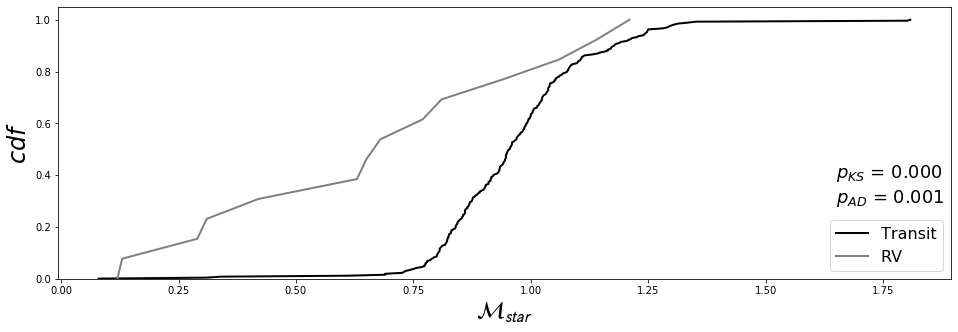

In [54]:
'''
Make stellar mass CDF
'''

ms_rv_solar = ms_final
ms_rv_solar = np.array(ms_rv_solar)
ms_transit_solar = np.concatenate([ms_dr25, ms_cks])
ms_transit_low = []
ms_rv_low = []
for i in range(len(detection_methods_mdwarves)):
    if detection_methods_mdwarves[i] == 'Transit':
        ms_transit_low.append(ms_mdwarves[i])
    elif detection_methods_mdwarves[i] == 'Radial Velocity':
        ms_rv_low.append(ms_mdwarves[i])
ms_transit = np.concatenate([ms_transit_solar, ms_transit_low])
ms_transit = np.sort(np.squeeze(ms_transit))
ms_rv = np.concatenate([ms_rv_solar, ms_rv_low])
ms_rv = np.sort(np.squeeze(ms_rv))

KS = np.array(stats.ks_2samp(ms_rv, ms_transit))[1]
AD = stats.anderson_ksamp([ms_rv, ms_transit])[2]

plt.figure(figsize=(16,5))
plt.plot(ms_transit, np.linspace(0, 1, len(ms_transit)), lw=2, color='black', label='Transit')
plt.plot(ms_rv, np.linspace(0, 1, len(ms_rv)), lw=2, color='grey', label='RV')
plt.text(1.65, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
plt.text(1.65, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
plt.xlabel(r'$\mathcal{M}_{\mathcal{star}}$', fontsize=24)
plt.ylim(0, 1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)